<a href="https://www.kaggle.com/code/rafaeljminaya/nba-3-point-shooting-analysis?scriptVersionId=196949675" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 0. ***Introduction***

From the ABA and NBA merger to the new In-Season Tournament, the NBA has been through many different eras, and each came with revolutionary changes to the game. One of the most important eras is today's 3-Point Revolution, whose inception can be traced to the implementation of the radical 3-Point line in 1976. Anyone who has followed the NBA closely over the past decade can see with their eyes the boom of the 3-point shot and how the product on the court is impacted greatly by it when in the decades before that was not the case.


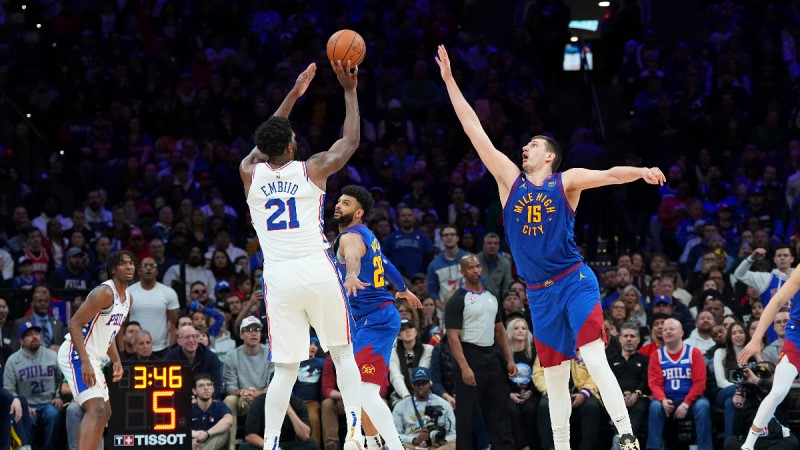

**Questions to keep in mind:**
1. When and how did the NBA 3-Point boom arrive within the past 20 years?
2. What are some common shooting habits that players today have opposed to their veteran counterparts from the early 2000s?

In [1]:
#Importing our packages and models
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
from matplotlib.patches import Circle, Rectangle, Arc
from matplotlib.ticker import PercentFormatter, FuncFormatter
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

# 1. ***Data Overview and Cleaning***

For this exploration of 3-point shooting, we'll be implementing the use of different NBA shooting datasets found on Kaggle. All DataFrames have been cleaned to have no missing or null values (please look into the code to see different processes applied to clean data).

### **Team Statistics Dataset**:

>Mostly comprised of Field Goals made and attempt rates by teams over the course of many seasons.

In [2]:
#Importing Team Stats DataFrame
team_totals = pd.read_csv('/kaggle/input/nba-datasets/Team Stats Per Game.csv')

#Only including the seasons between 1999 and 2023
team_totals = team_totals.loc[(team_totals['season'] < 2024) & (team_totals['season'] > 1999)]

#Removing missing values which will get rid of season average rows in dataset that will affect our analysis
team_totals.dropna(inplace=True)

#Summary of dataset
print(team_totals.info())
team_totals.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 715 entries, 31 to 768
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season         715 non-null    int64  
 1   lg             715 non-null    object 
 2   team           715 non-null    object 
 3   abbreviation   715 non-null    object 
 4   playoffs       715 non-null    bool   
 5   g              715 non-null    float64
 6   mp_per_game    715 non-null    float64
 7   fg_per_game    715 non-null    float64
 8   fga_per_game   715 non-null    float64
 9   fg_percent     715 non-null    float64
 10  x3p_per_game   715 non-null    float64
 11  x3pa_per_game  715 non-null    float64
 12  x3p_percent    715 non-null    float64
 13  x2p_per_game   715 non-null    float64
 14  x2pa_per_game  715 non-null    float64
 15  x2p_percent    715 non-null    float64
 16  ft_per_game    715 non-null    float64
 17  fta_per_game   715 non-null    float64
 18  ft_percent    

season           g  mp_per_game  fg_per_game  fga_per_game  \
count   715.000000  715.000000   715.000000   715.000000    715.000000   
mean   2011.566434   80.427972   241.744336    37.866573     83.259860   
std       6.904267    4.289104     0.878250     2.501213      4.015505   
min    2000.000000   64.000000   240.000000    31.300000     74.300000   
25%    2006.000000   82.000000   241.200000    36.100000     80.300000   
50%    2012.000000   82.000000   241.800000    37.600000     82.800000   
75%    2018.000000   82.000000   242.350000    39.500000     86.200000   
max    2023.000000   82.000000   244.900000    44.700000     94.400000   

       fg_percent  x3p_per_game  x3pa_per_game  x3p_percent  x2p_per_game  \
count  715.000000    715.000000     715.000000   715.000000    715.000000   
mean     0.454678      7.834965      21.942517     0.355351     30.036643   
std      0.016335      3.020570       8.159599     0.019151      2.046552   
min      0.408000      2.500000       7.800000     0.278000     23.100000   
25%      0.443000      5.500000      15.600000     0.344000     28.750000   
50%      0.454000      7.100000      19.800000     0.355000     30.200000   
75%      0.466000     10.100000      28.400000     0.368000     31.450000   
max      0.504000     16.700000      45.400000     0.416000     36.300000   

       ...  ft_percent  orb_per_game  drb_per_game  trb_per_game  \
count  ...  715.000000    715.000000     715.00000    715.000000   
mean   ...    0.760617     11.028112      31.72028     42.745035   
std    ...    0.030019      1.370173       2.22220      2.067262   
min    ...    0.660000      7.600000      26.90000     36.900000   
25%    ...    0.743000     10.100000      30.00000     41.300000   
50%    ...    0.761000     11.000000      31.40000     42.700000   
75%    ...    0.781000     11.950000      33.30000     44.100000   
max    ...    0.839000     16.400000      42.20000     51.700000   

       ast_per_game  stl_per_game  blk_per_game  tov_per_game  pf_per_game  \
count    715.000000    715.000000    715.000000    715.000000   715.000000   
mean      22.359860      7.596643      4.894266     14.439441    20.920420   
std        2.240385      0.853475      0.802924      1.175311     1.747388   
min       17.400000      5.500000      2.400000     11.100000    16.600000   
25%       20.800000      7.000000      4.300000     13.700000    19.700000   
50%       22.100000      7.500000      4.800000     14.500000    20.800000   
75%       23.800000      8.200000      5.400000     15.100000    22.100000   
max       30.400000     10.300000      8.200000     19.000000    27.100000   

       pts_per_game  
count    715.000000  
mean     101.683776  
std        7.339665  
min       84.200000  
25%       96.350000  
50%      100.500000  
75%      106.600000  
max      120.700000  

[8 rows x 24 columns]

In [3]:
#Displaying Dataset
team_totals

season   lg                 team abbreviation  playoffs     g  \
31     2023  NBA        Atlanta Hawks          ATL     False  82.0   
32     2023  NBA       Boston Celtics          BOS     False  82.0   
33     2023  NBA        Brooklyn Nets          BRK     False  82.0   
34     2023  NBA        Chicago Bulls          CHI     False  82.0   
35     2023  NBA    Charlotte Hornets          CHO     False  82.0   
..      ...  ...                  ...          ...       ...   ...   
764    2000  NBA  Seattle SuperSonics          SEA      True  82.0   
765    2000  NBA      Toronto Raptors          TOR      True  82.0   
766    2000  NBA            Utah Jazz          UTA      True  82.0   
767    2000  NBA  Vancouver Grizzlies          VAN     False  82.0   
768    2000  NBA   Washington Wizards          WAS     False  82.0   

     mp_per_game  fg_per_game  fga_per_game  fg_percent  ...  ft_percent  \
31         242.1         44.6          92.4       0.483  ...       0.818   
32         243.7         42.2          88.8       0.475  ...       0.812   
33         240.6         41.5          85.1       0.487  ...       0.800   
34         242.7         42.5          86.8       0.490  ...       0.809   
35         241.8         41.3          90.4       0.457  ...       0.749   
..           ...          ...           ...         ...  ...         ...   
764        241.2         37.9          84.7       0.447  ...       0.695   
765        240.9         36.3          83.9       0.433  ...       0.765   
766        240.9         36.1          77.8       0.464  ...       0.773   
767        242.1         35.3          78.5       0.449  ...       0.774   
768        241.5         36.7          81.5       0.451  ...       0.743   

     orb_per_game  drb_per_game  trb_per_game  ast_per_game  stl_per_game  \
31           11.2          33.2          44.4          25.0           7.1   
32            9.7          35.6          45.3          26.7           6.4   
33            8.2          32.3          40.5          25.5           7.1   
34            8.5          33.9          42.4          24.5           7.9   
35           11.0          33.5          44.5          25.1           7.7   
..            ...           ...           ...           ...           ...   
764          12.7          30.3          43.0          22.9           8.0   
765          13.4          29.9          43.3          23.7           8.1   
766          11.4          29.6          41.0          24.9           7.7   
767          12.3          28.3          40.6          20.7           7.4   
768          13.0          29.7          42.7          21.6           7.2   

     blk_per_game  tov_per_game  pf_per_game  pts_per_game  
31            4.9          12.9         18.8         118.4  
32            5.2          13.4         18.8         117.9  
33            6.2          13.7         21.1         113.4  
34            4.5          13.4         18.9         113.1  
35            5.2          14.2         20.3         111.0  
..            ...           ...          ...           ...  
764           4.2          14.0         21.7          99.1  
765           6.6          13.9         24.3          97.2  
766           5.4          14.9         24.5          96.5  
767           4.2          16.8         22.9          93.9  
768           4.7          16.1         26.2          96.6  

[715 rows x 28 columns]

### **Individual Player Shooting Dataset**:

>Focuses on providing player shooting rates from different distances on the court.

In [4]:
#Import Player Shooting DataFrame
player_shooting = pd.read_csv('/kaggle/input/nba-datasets/Player Shooting.csv')


#Drop columns that have no use in our analysis and columns where most values were NA and 
player_shooting.drop(['num_heaves_made', 'num_heaves_attempted', 'birth_year', 'num_of_dunks', 
                      'percent_dunks_of_fga', 'percent_assisted_x2p_fg', 'percent_assisted_x3p_fg', 
                      'percent_corner_3s_of_3pa', 'corner_3_point_percent'], 
                     axis=1, 
                     inplace=True)

#Clean up postion column as there are players with double postion labels (ex: "PG-SG")
player_shooting['pos'] = player_shooting['pos'].str.replace('-SG', '')
player_shooting['pos'] = player_shooting['pos'].str.replace('-SF', '')
player_shooting['pos'] = player_shooting['pos'].str.replace('-C', '')
player_shooting['pos'] = player_shooting['pos'].str.replace('-PF', '')
player_shooting['pos'] = player_shooting['pos'].str.replace('-PG', '')
player_shooting['pos'] = player_shooting['pos'].str.replace('-PG-SF', '')

#Renaming some columns in DataFrame for clarity
player_shooting.rename(columns = {'pos':'Position', 'lg':'league', 'tm':'team',
                                  'g':'game within season', 'mp':'minutes played'}, 
                       inplace = True)

#Only include the seasons between 1999 and 2023
player_shooting = player_shooting.loc[(player_shooting['season'] < 2024) & (player_shooting['season'] > 1999)]

#Drop missing values values
player_shooting.dropna(inplace=True)

#Show summary of dataset
print(player_shooting.info())
player_shooting.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 11198 entries, 415 to 14835
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   seas_id                        11198 non-null  int64  
 1   season                         11198 non-null  int64  
 2   player_id                      11198 non-null  int64  
 3   player                         11198 non-null  object 
 4   Position                       11198 non-null  object 
 5   age                            11198 non-null  int64  
 6   experience                     11198 non-null  int64  
 7   league                         11198 non-null  object 
 8   team                           11198 non-null  object 
 9   game within season             11198 non-null  int64  
 10  minutes played                 11198 non-null  int64  
 11  fg_percent                     11198 non-null  float64
 12  avg_dist_fga                   11198 non-null  fl

seas_id        season    player_id           age    experience  \
count  11198.000000  11198.000000  11198.00000  11198.000000  11198.000000   
mean   23979.231202   2012.316842   3728.47321     26.690927      5.860600   
std     4147.212865      6.919883    594.41393      4.260048      4.027695   
min    16714.000000   2000.000000   2112.00000     18.000000      1.000000   
25%    20405.250000   2006.000000   3283.00000     23.000000      2.000000   
50%    24035.500000   2013.000000   3730.50000     26.000000      5.000000   
75%    27544.750000   2018.000000   4174.00000     30.000000      9.000000   
max    31135.000000   2023.000000   5107.00000     43.000000     22.000000   

       game within season  minutes played    fg_percent  avg_dist_fga  \
count        11198.000000    11198.000000  11198.000000  11198.000000   
mean            52.381675     1259.068226      0.436342     13.291347   
std             23.000714      842.113884      0.066238      4.237887   
min              1.000000       12.000000      0.000000      1.000000   
25%             33.000000      517.000000      0.400000     10.600000   
50%             57.000000     1164.000000      0.435000     13.700000   
75%             73.000000     1919.000000      0.472000     16.300000   
max             85.000000     3485.000000      0.765000     24.800000   

       percent_fga_from_x2p_range  ...  percent_fga_from_x3_10_range  \
count                11198.000000  ...                  11198.000000   
mean                     0.708868  ...                      0.148260   
std                      0.201628  ...                      0.084851   
min                      0.090000  ...                      0.004000   
25%                      0.562000  ...                      0.084250   
50%                      0.705000  ...                      0.133000   
75%                      0.891000  ...                      0.196000   
max                      0.999000  ...                      0.618000   

       percent_fga_from_x10_16_range  percent_fga_from_x16_3p_range  \
count                   11198.000000                   11198.000000   
mean                        0.104938                       0.177156   
std                         0.063382                       0.121788   
min                         0.002000                       0.001000   
25%                         0.059000                       0.079000   
50%                         0.093000                       0.159000   
75%                         0.138000                       0.253000   
max                         0.532000                       0.783000   

       percent_fga_from_x3p_range  fg_percent_from_x2p_range  \
count                11198.000000               11198.000000   
mean                     0.291137                   0.473126   
std                      0.201627                   0.074191   
min                      0.001000                   0.000000   
25%                      0.109000                   0.432000   
50%                      0.295000                   0.473000   
75%                      0.438000                   0.515000   
max                      0.910000                   0.857000   

       fg_percent_from_x0_3_range  fg_percent_from_x3_10_range  \
count                11198.000000                 11198.000000   
mean                     0.609515                     0.365339   
std                      0.116071                     0.141768   
min                      0.000000                     0.000000   
25%                      0.551000                     0.300000   
50%                      0.615000                     0.377000   
75%                      0.675000                     0.442000   
max                      1.000000                     1.000000   

       fg_percent_from_x10_16_range  fg_percent_from_x16_3p_range  \
count                  11198.000000                  11198.000000   
mean                       0.365611                 

In [5]:
#Preview Dataset
player_shooting

seas_id  season  player_id            player Position  age  experience  \
415      30458    2023       5025        A.J. Green       SG   23           1   
419      30467    2023       5027        AJ Griffin       SF   19           1   
420      30462    2023       4219      Aaron Gordon       PF   27           9   
421      30463    2023       4582     Aaron Holiday       PG   26           5   
422      30464    2023       4805     Aaron Nesmith       SF   23           3   
...        ...     ...        ...               ...      ...  ...         ...   
14829    17202    2000       3225  Wally Szczerbiak       SF   22           1   
14830    17203    2000       2758     Walt Williams       SF   29           8   
14831    17204    2000       3034    Walter McCarty       PF   25           4   
14833    17206    2000       2889     Wesley Person       SG   28           6   
14835    17208    2000       3227     William Avery       PG   20           1   

      league team  game within season  ...  percent_fga_from_x3_10_range  \
415      NBA  MIL                  35  ...                         0.016   
419      NBA  ATL                  72  ...                         0.165   
420      NBA  DEN                  68  ...                         0.183   
421      NBA  ATL                  63  ...                         0.168   
422      NBA  IND                  73  ...                         0.136   
...      ...  ...                 ...  ...                           ...   
14829    NBA  MIN                  73  ...                         0.127   
14830    NBA  HOU                  76  ...                         0.068   
14831    NBA  BOS                  61  ...                         0.087   
14833    NBA  CLE                  79  ...                         0.063   
14835    NBA  MIN                  59  ...                         0.094   

       percent_fga_from_x10_16_range  percent_fga_from_x16_3p_range  \
415                            0.032                          0.072   
419                            0.173                          0.075   
420                            0.064                          0.037   
421                            0.132                          0.077   
422                            0.063                          0.020   
...                              ...                            ...   
14829                          0.154                          0.333   
14830                          0.085                          0.239   
14831                          0.122                          0.191   
14833                          0.168                          0.271   
14835                          0.072                          0.282   

       percent_fga_from_x3p_range  fg_percent_from_x2p_range  \
415                         0.840                      0.450   
419                         0.486                      0.536   
420                         0.227                      0.628   
421                         0.400                      0.424   
422                         0.532                      0.496   
...                           ...                        ...   
14829                       0.117                      0.531   
14830                       0.383                      0.500   
14831                       0.478                      0.367   
14833                       0.382                      0.431   
14835                       0.348                      0.322   

       fg_percent_from_x0_3_range  fg_percent_from_x3_10_range  \
415                         0.400                        0.500   
419                         0.630                        0.568   
420                         0.782                        0.388   
421                         0.612                        0.216   
422                         0.639                        0.263   
...                           ...                          ...   
14829                       0.700    

### **Positional Shooting Datasets**: (Only showing one dataset out of group)

>These collection of datasets provide positional data of everyshot attempted by every player in the NBA within the specified season.

In [6]:
#Import out shot location datasets for the years we will be using
shots_04 = pd.read_csv("/kaggle/input/nba-datasets/NBA_2004_Shots.csv")
shots_07 = pd.read_csv("/kaggle/input/nba-datasets/NBA_2007_Shots.csv")
shots_11 = pd.read_csv("/kaggle/input/nba-datasets/NBA_2011_Shots.csv")
shots_15 = pd.read_csv("/kaggle/input/nba-datasets/NBA_2015_Shots.csv")
shots_19 = pd.read_csv("/kaggle/input/nba-datasets/NBA_2019_Shots.csv")
shots_23 = pd.read_csv("/kaggle/input/nba-datasets/NBA_2023_Shots.csv")


##############
#Create a list holding each of our DataFrames to make editing and cleaning more efficent
all_years = [shots_04, shots_07, shots_11, shots_15, shots_19, shots_23] 

#Change decimal place in X and Y coordinates to fit shot chart we'll be using
for df in all_years:
    df[['LOC_X', 'LOC_Y']] = (df[['LOC_X', 'LOC_Y']]*10)

#Use Feature Encoding on the SHOT_MADE column for use in our ML model later
for df in all_years:
    le = LabelEncoder()
    label = le.fit_transform(df['SHOT_MADE'])
    label
    df.loc[:, 'SHOT_MADE'] = label

#Moving SHOT_MADE to end of each Dataframe for use in our ML model later
for df in all_years:
    df.insert(len(df.columns)-1, 'SHOT_MADE', df.pop('SHOT_MADE'))

#Dropping unnecessary columns    
for df in all_years:
    df.drop(['SEASON_1', 'TEAM_ID', 'POSITION_GROUP', 'POSITION', 
       'GAME_DATE', 'GAME_ID','HOME_TEAM', 'AWAY_TEAM'], axis=1, inplace=True)
    
#Simplifing Action_Type value names
jumper = ['Fadeaway Jump Shot', 'Turnaround Jump Shot', 'Running Jump Shot', 'Jump Bank Shot', 'Hook Bank Shot', 
          'Jump Hook Shot', 'Running Hook Shot', 'Hook Shot', 'Turnaround Hook Shot', 'Driving Hook Shot', 
          'Driving Jump Shot']

layup = ['Driving Layup Shot', 'Driving Finger Roll Shot',  'Running Layup Shot',
         'Reverse Layup Shot', 'Running Finger Roll Shot', 'Alley Oop Layup shot', 'Finger Roll Shot', 
       'Turnaround Finger Roll Shot', 'Running Tip Shot', 'Tip Shot', 'Turnaround Layup Shot']

dunk = ['Alley Oop Dunk Shot', 'Slam Dunk Shot', 'Driving Dunk Shot', 'Reverse Dunk Shot', 
        'Follow Up Dunk Shot', 'Running Dunk Shot']

for a in jumper:
    shots_04['ACTION_TYPE'] = shots_04['ACTION_TYPE'].str.replace(str(a), 'Jump Shot')

for b in layup:
    shots_04['ACTION_TYPE'] = shots_04['ACTION_TYPE'].str.replace(str(b), 'Layup Shot')

for c in dunk:
    shots_04['ACTION_TYPE'] = shots_04['ACTION_TYPE'].str.replace(str(c), 'Dunk Shot')
##############
    
    
#All DataFrames have the same form, previewing just one
print(shots_04.info())
shots_04.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189803 entries, 0 to 189802
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   SEASON_2       189803 non-null  object 
 1   TEAM_NAME      189803 non-null  object 
 2   PLAYER_ID      189803 non-null  int64  
 3   PLAYER_NAME    189803 non-null  object 
 4   EVENT_TYPE     189803 non-null  object 
 5   ACTION_TYPE    189803 non-null  object 
 6   SHOT_TYPE      189803 non-null  object 
 7   BASIC_ZONE     189803 non-null  object 
 8   ZONE_NAME      189803 non-null  object 
 9   ZONE_ABB       189803 non-null  object 
 10  ZONE_RANGE     189803 non-null  object 
 11  LOC_X          189803 non-null  float64
 12  LOC_Y          189803 non-null  float64
 13  SHOT_DISTANCE  189803 non-null  int64  
 14  QUARTER        189803 non-null  int64  
 15  MINS_LEFT      189803 non-null  int64  
 16  SECS_LEFT      189803 non-null  int64  
 17  SHOT_MADE      189803 non-nul

PLAYER_ID          LOC_X          LOC_Y  SHOT_DISTANCE  \
count  189803.000000  189803.000000  189803.000000  189803.000000   
mean     1530.123844       2.739999     119.843994      11.595955   
std       757.888105     111.105957      82.611039       9.546158   
min        15.000000    -250.000000       0.500000       0.000000   
25%       947.000000     -61.000000      52.500000       0.000000   
50%      1730.000000       0.000000      83.500000      13.000000   
75%      2200.000000      71.000000     182.500000      19.000000   
max      2724.000000     248.000000     908.500000      87.000000   

             QUARTER      MINS_LEFT      SECS_LEFT      SHOT_MADE  
count  189803.000000  189803.000000  189803.000000  189803.000000  
mean        2.475388       5.333588      28.669547       0.438639  
std         1.138648       3.472361      17.466134       0.496222  
min         1.000000       0.000000       0.000000       0.000000  
25%         1.000000       2.000000      14.000000       0.000000  
50%         2.000000       5.000000      29.000000       0.000000  
75%         3.000000       8.000000      44.000000       1.000000  
max         7.000000      12.000000      59.000000       1.000000

In [7]:
#All DataFrames have the same form, previewing just one
shots_04

SEASON_2               TEAM_NAME  PLAYER_ID       PLAYER_NAME  \
0       2003-04      Los Angeles Lakers        977       Kobe Bryant   
1       2003-04  Portland Trail Blazers        757  Damon Stoudamire   
2       2003-04      Los Angeles Lakers        977       Kobe Bryant   
3       2003-04  Portland Trail Blazers        757  Damon Stoudamire   
4       2003-04  Portland Trail Blazers        757  Damon Stoudamire   
...         ...                     ...        ...               ...   
189798  2003-04      Philadelphia 76ers       2422      John Salmons   
189799  2003-04       San Antonio Spurs       1938     Manu Ginobili   
189800  2003-04      Los Angeles Lakers        406  Shaquille O'Neal   
189801  2003-04            Phoenix Suns       2063      Jake Voskuhl   
189802  2003-04              Miami Heat       2548       Dwyane Wade   

         EVENT_TYPE ACTION_TYPE       SHOT_TYPE             BASIC_ZONE  \
0         Made Shot   Jump Shot  3PT Field Goal      Above the Break 3   
1         Made Shot  Layup Shot  2PT Field Goal        Restricted Area   
2       Missed Shot   Jump Shot  2PT Field Goal              Mid-Range   
3         Made Shot   Jump Shot  2PT Field Goal              Mid-Range   
4       Missed Shot   Jump Shot  2PT Field Goal              Mid-Range   
...             ...         ...             ...                    ...   
189798    Made Shot   Jump Shot  3PT Field Goal          Left Corner 3   
189799  Missed Shot   Jump Shot  3PT Field Goal      Above the Break 3   
189800  Missed Shot   Jump Shot  2PT Field Goal  In The Paint (Non-RA)   
189801  Missed Shot  Layup Shot  2PT Field Goal        Restricted Area   
189802  Missed Shot  Layup Shot  2PT Field Goal        Restricted Area   

               ZONE_NAME ZONE_ABB       ZONE_RANGE  LOC_X  LOC_Y  \
0       Left Side Center       LC          24+ ft.  200.0  213.5   
1                 Center        C  Less Than 8 ft.   -0.0   52.5   
2       Left Side Center       LC        16-24 ft.  133.0  244.5   
3              Left Side        L        16-24 ft.  164.0  139.5   
4             Right Side        R        16-24 ft. -158.0   78.5   
...                  ...      ...              ...    ...    ...   
189798         Left Side        L          24+ ft.  233.0   95.5   
189799  Left Side Center       LC          24+ ft.  151.0  258.5   
189800            Center        C  Less Than 8 ft.  -47.0   98.5   
189801            Center        C  Less Than 8 ft.  -23.0   60.5   
189802            Center        C  Less Than 8 ft.   -0.0   52.5   

        SHOT_DISTANCE  QUARTER  MINS_LEFT  SECS_LEFT  SHOT_MADE  
0                  25        6          0          0          1  
1                   0        6          0          2          1  
2                  23        6          0          9          0  
3                  18        6          0         31          1  
4                  16        6          0         55          0  
...               ...      ...        ...        ...        ...  
189798             23        1         11         21          1  
189799             25        1         11         24          0  
189800              6        1         11         39          0  
189801              2        1         11         42          0  
189802              0        1         11         48          0  

[189803 rows x 18 columns]

# 2. ***Shooting Breakdowns***    

## 2.1  **3-Pointers vs 2-Pointers**

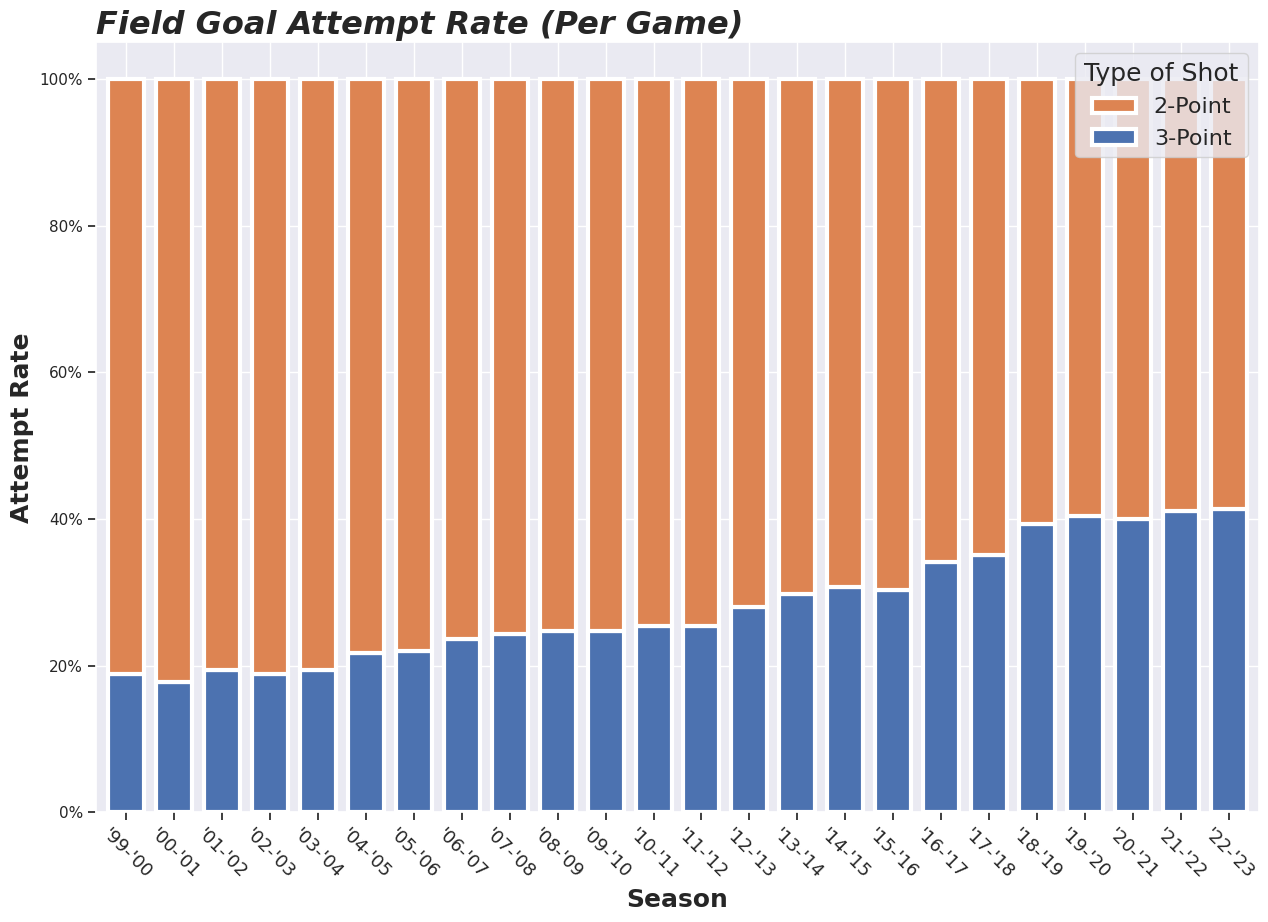

In [8]:
#Setting up the plot
sns.set(rc={"figure.figsize":(15, 10)})
sns.color_palette("tab10")
attempted = player_shooting.groupby('season')[['percent_fga_from_x3p_range', 'percent_fga_from_x2p_range']]\
            .mean()\
            .reset_index()

#Plotting
ax = attempted.set_index('season').plot(kind='bar',
                                        stacked=True,
                                        width = 0.75,
                                        edgecolor = "white", 
                                        linewidth=3)

#Configuring titles
ax.axes.set_title('Field Goal Attempt Rate (Per Game)', 
                  fontsize=23, 
                  loc='left', 
                  fontweight='bold', 
                  fontstyle='oblique')
ax.set_xlabel("Season", 
              fontsize=18, 
              fontweight='bold')
ax.set_ylabel("Attempt Rate", 
              fontsize=18, 
              fontweight='bold')

#Formating the yticklabels to be percentages instead of decimals
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

#Formating the xticklabels
ax.set_xticks(range(len(attempted.set_index('season'))))
ax.set_xticklabels(["'99-'00", "'00-'01", "'01-'02", "'02-'03", 
                    "'03-'04", "'04-'05", "'05-'06", "'06-'07", 
                    "'07-'08", "'08-'09", "'09-'10", "'10-'11", 
                    "'11-'12", "'12-'13", "'13-'14", "'14-'15", 
                    "'15-'16", "'16-'17", "'17-'18", "'18-'19", 
                    "'19-'20", "'20-'21", "'21-'22", "'22-'23"], 
                   rotation=-45, 
                   size=13)
ax.tick_params(bottom=True, 
               left=True)

#Configuring the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), 
          reversed(["3-Point", "2-Point"]), 
          title='Type of Shot', 
          loc='upper right',
          title_fontsize= 18,
          fontsize = 16)

Over the past 20 years, we see a gradual growth of 3s being attempted per game by players. From 1 out of every 5 shots attempted being a 3-pointer in the *1999-2000* season to almost 2 in every 5 shots in the present NBA being a 3. 

To some, this might not be an astronomical jump in shooting rates but it's staggering to see such a jump, especially for on-lookers of the sport who felt the shockwaves of such a change in player output with such things as points per game and Field Goal percentages.

## 2.2 **Are Players Making 3s?**

Focusing on Field Goal (FG) percentage did this three-point boom have an effect of how well players where shooting the 3 ball?

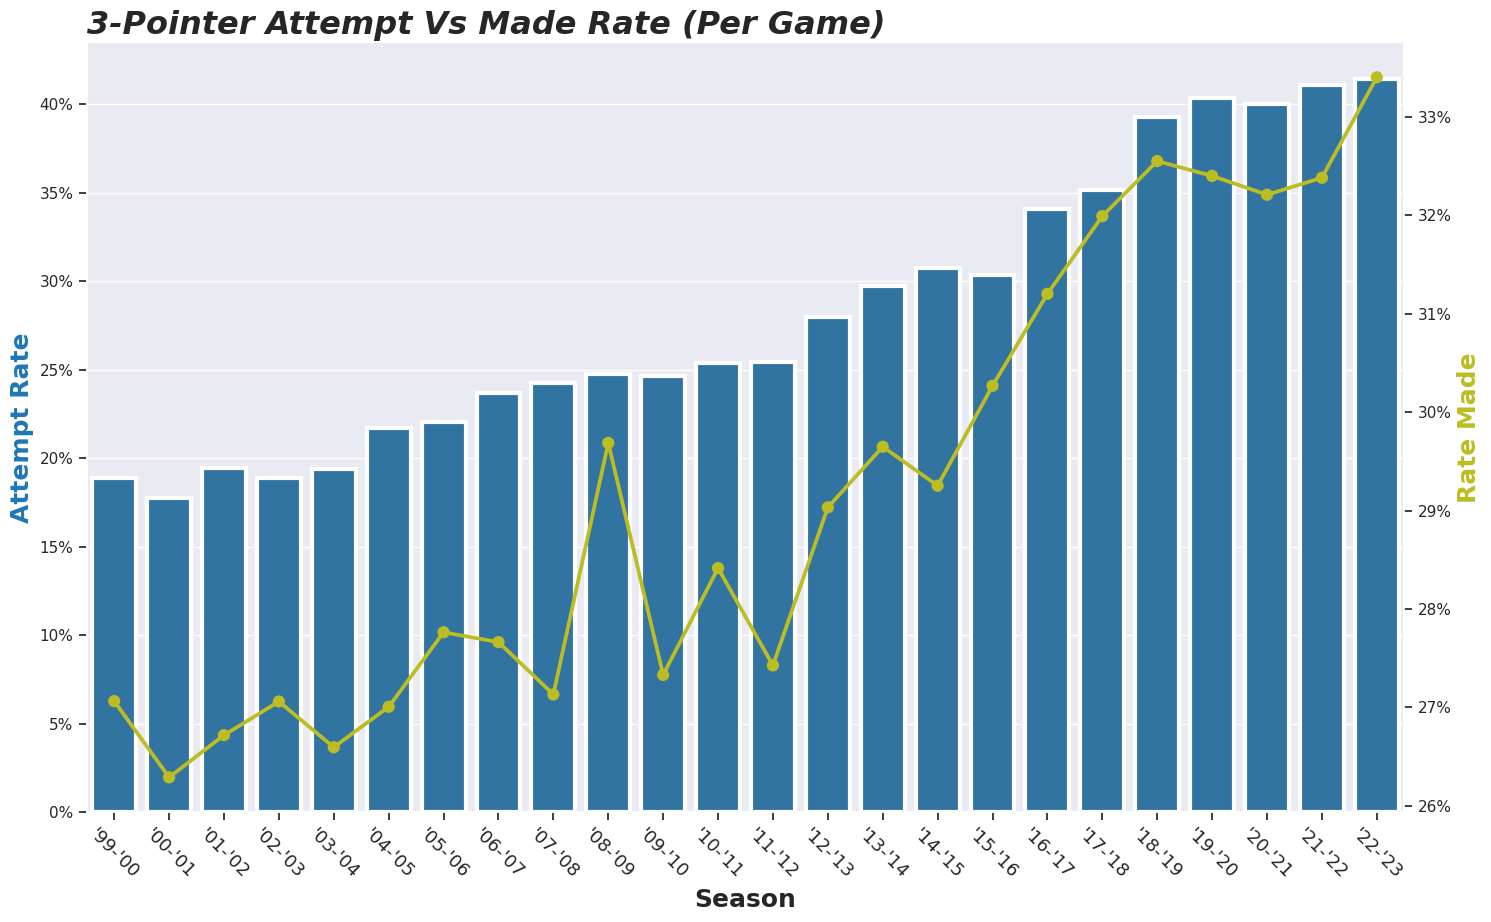

In [9]:
#Setting up the plot
fig, ax = plt.subplots(figsize=(17, 10))
sns.set_theme(style="dark", palette='binary')

#Plotting
g = sns.barplot(data=player_shooting, 
                x='season', 
                y='percent_fga_from_x3p_range', 
                linewidth=3, 
                errorbar=None, 
                ax=ax, 
                color='tab:blue',
                edgecolor = "white")

ax2 = ax.twinx()
g = sns.pointplot(data=player_shooting, 
                  x='season', 
                  y='fg_percent_from_x3p_range',  
                  errorbar=None, 
                  ax=ax2, 
                  color='tab:olive')


#Configuring titles
ax.axes.set_title('3-Pointer Attempt Vs Made Rate (Per Game)', 
                  fontsize=23, 
                  loc='left', 
                  fontweight='bold', 
                  fontstyle='oblique')
ax.set_xlabel("Season", 
              fontsize=18, 
              fontweight='bold')
ax.set_ylabel("Attempt Rate", 
              fontsize=18, 
              fontweight='bold', 
              color='tab:blue')
ax2.set_ylabel("Rate Made", 
               fontsize=18, 
               fontweight='bold', 
               color='tab:olive')


#Formating the y-labels to be percentages instead of decimals
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

#Formating the x-labels
ax.set_xticks(range(24))
ax.set_xticklabels(["'99-'00", "'00-'01", "'01-'02", "'02-'03", 
                    "'03-'04", "'04-'05", "'05-'06", "'06-'07", 
                    "'07-'08", "'08-'09", "'09-'10", "'10-'11", 
                    "'11-'12", "'12-'13", "'13-'14", "'14-'15", 
                    "'15-'16", "'16-'17", "'17-'18", "'18-'19", 
                    "'19-'20", "'20-'21", "'21-'22", "'22-'23"], 
                   rotation=-45, 
                   size=13)
ax.tick_params(bottom=True, left=True)

Visually we see something interesting happen with FG percentage as we do with FGA rates as both trend upward as we approach the present. Even while shooting a higher percentage of 3s NBA players maintained and kept up by making their 3s at a high level. 

Looking closely we can also observe an inflection point in the *2014-2015* season, where the rate of 3-pointers made continuously goes upwards with a slight dip that then goes back up in the 2022-2023 season (which exceeds any 3-point made rates in any of the past 20 NBA seasons).

## 2.3 **3-Point Shot by Position**

Now that we see this from a top-down point of view looking at all players, what kind of effect did the 3-point shot have on each of the five positions in the NBA, each obviously having their own unique strengths and weakness when it comes to shooting the basketball.

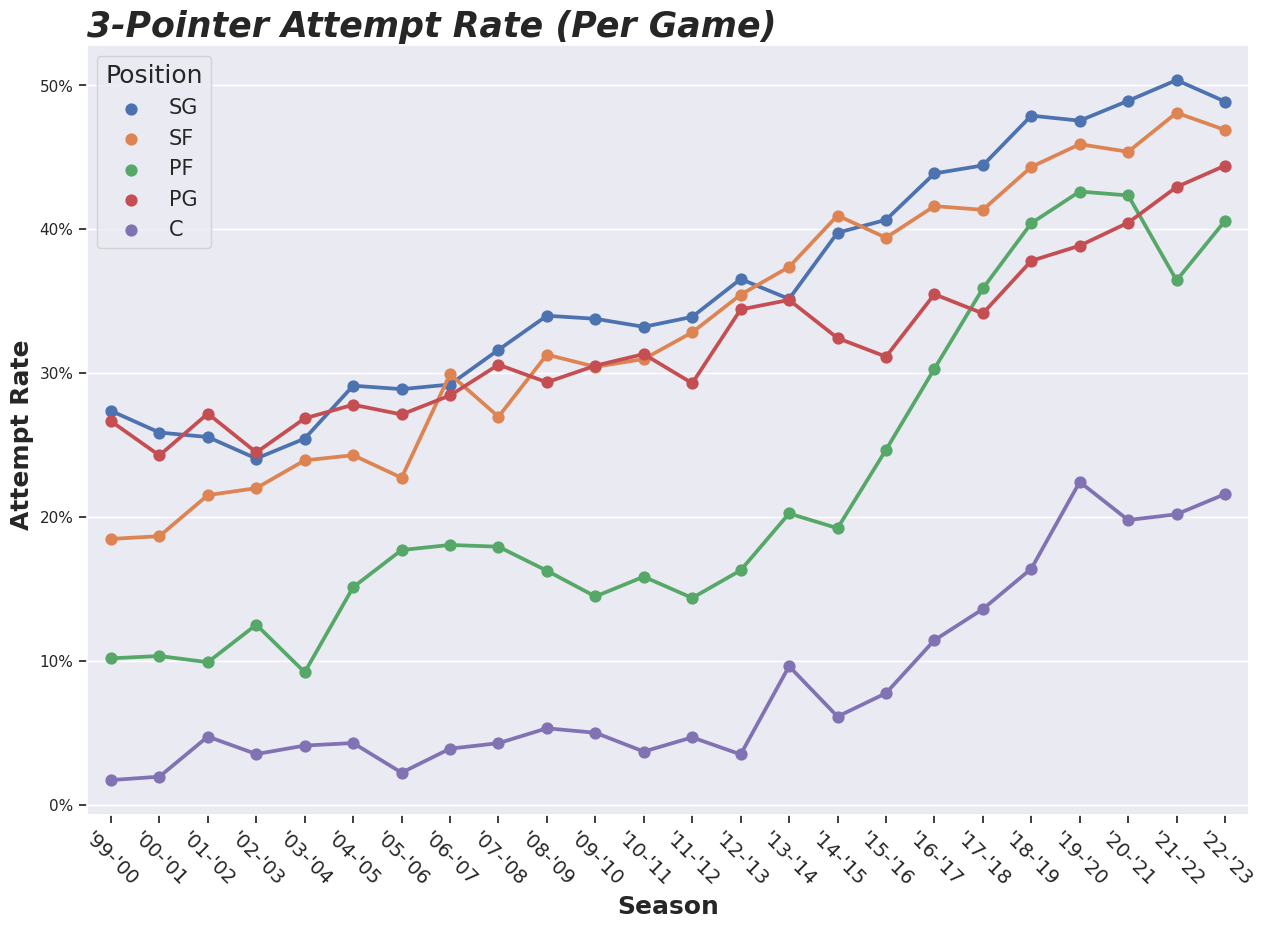

In [10]:
#Setting up the plot
sns.set(rc={"figure.figsize":(15, 10)})
sns.set_style("darkgrid")
sns.color_palette("tab10")

#Plotting
ax = sns.pointplot(data=player_shooting, 
                   x='season', 
                   y='percent_fga_from_x3p_range',
                   errorbar=None, 
                   hue='Position')
ax.tick_params(bottom=True, 
               left=True)


#Configuring titles
ax.axes.set_title("3-Pointer Attempt Rate (Per Game)", 
                  fontsize=25, 
                  loc='left', 
                  fontweight='bold', 
                  fontstyle='oblique')
ax.set_xlabel("Season", 
              fontsize=18, 
              fontweight='bold')
ax.set_ylabel("Attempt Rate ", 
              fontsize=18, 
              fontweight='bold')


#Formating the y-labels to be percentages instead of decimals
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

#Formating the x-labels
ax.set_xticks(range(24))
ax.set_xticklabels(["'99-'00", "'00-'01", "'01-'02", "'02-'03", 
                    "'03-'04", "'04-'05", "'05-'06", "'06-'07", 
                    "'07-'08", "'08-'09", "'09-'10", "'10-'11", 
                    "'11-'12", "'12-'13", "'13-'14", "'14-'15", 
                    "'15-'16", "'16-'17", "'17-'18", "'18-'19", 
                    "'19-'20", "'20-'21", "'21-'22", "'22-'23"], 
                   rotation=-45, 
                   size=14)


#Configuring legend
ax.legend(title='Position', 
          loc='upper left', 
          title_fontsize= 18, 
          fontsize = 15)

Initially, at the start of the millennia we see the 3 positions with most long-range shooting proficiency **(see next graph)** Point Guards (PG), Shooting Guards (SG), and Small Forwards (SF) maintain high rates of 3-Point attempts ranging from about 20% to 30% per game. The two remaining positions, Centers (C) and Power Forwards (PF) start the millennia shooting an incredibly low rate of 3s with PFs shooting them at a rate of about 10% per game and Cs closer to 2%. 

As time progresses we see not only a spike in attempts for PGs, SGs, and SFs as one would expect with players with the skill set to do so but also from PFs and Cs who historically are opposites from a shooting skills standpoint. PFs would go on to shoot 3s at a rate of past 40% per game in some seasons while Cs who would barely attempt a 3-Pointers in the early 2000s now shot them at a rate just above 20% per game.

For folks who watch NBA basketball regularly this change can be seen on the court with the last two winners of the NBA MVP award being 2 Centers (Joel Embiid and Nikola Jokic) who shot an extensive amount of 3s in each of their MVP-winning seasons and even before.

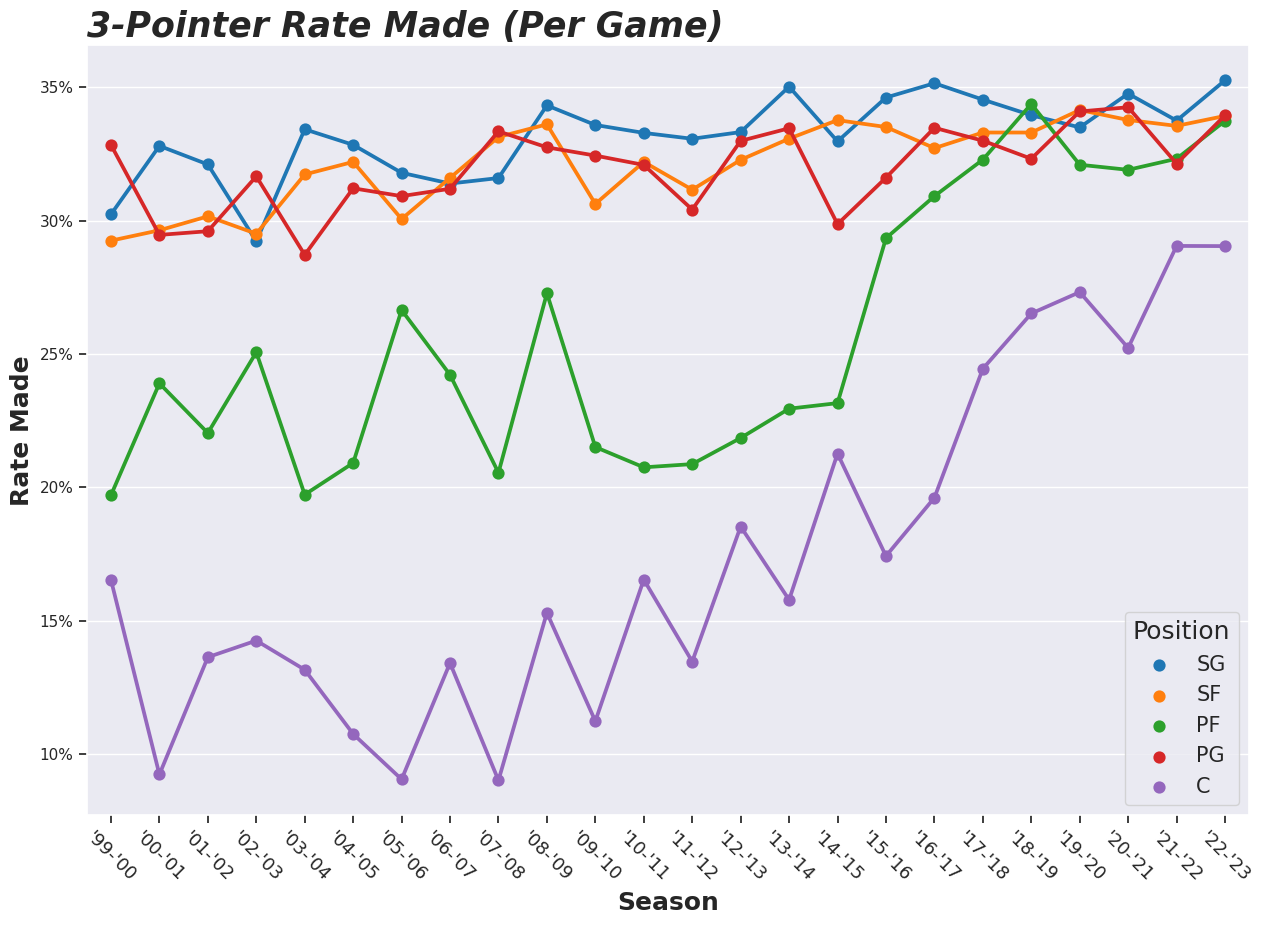

In [11]:
#Setting up the plot
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_theme(style="darkgrid", palette="tab10")

#Plotting
g = sns.pointplot(data=player_shooting, 
                  x='season', 
                  y='fg_percent_from_x3p_range', 
                  errorbar=None, 
                  hue='Position', 
                  ax=ax)
ax.tick_params(bottom=True, 
               left=True)

#Configuring titles
ax.axes.set_title('3-Pointer Rate Made (Per Game)', 
                  fontsize=25, 
                  loc='left', 
                  fontweight='bold', 
                  fontstyle='oblique')
ax.set_xlabel("Season", 
              fontsize=18, 
              fontweight='bold')
ax.set_ylabel("Rate Made", 
              fontsize=18, 
              fontweight='bold')


#Formating the y-labels to be percentages instead of decimals
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

#Formating the x-labels
ax.set_xticks(range(24))
ax.set_xticklabels(["'99-'00", "'00-'01", "'01-'02", "'02-'03", 
                    "'03-'04", "'04-'05", "'05-'06", "'06-'07", 
                    "'07-'08", "'08-'09", "'09-'10", "'10-'11", 
                    "'11-'12", "'12-'13", "'13-'14", "'14-'15", 
                    "'15-'16", "'16-'17", "'17-'18", "'18-'19", 
                    "'19-'20", "'20-'21", "'21-'22", "'22-'23"], 
                   rotation=-45, 
                   size=13)

#Configuring legend
ax.legend(title='Position', 
          loc='lower right',
          title_fontsize= 18,
          fontsize = 15)

Looking at the rate at which player was actually making 3s it's not surprising to see PGs, SGs, and SFs shooting at such a high rate but what's more surprising is PFs and Cs catching up with their shorter and quicker counterparts in the 3-point making department.

## 2.4 **Team Success**

Is there actually any team success coming from these 3s? Using Playoff appearances by a team as our metric of success (making the playoffs signifies you are one of the top 8 teams in your respective Conference), I've illustrated the number of attempts from the 3-point range for a team that made the playoffs in that specific season and those who did not.

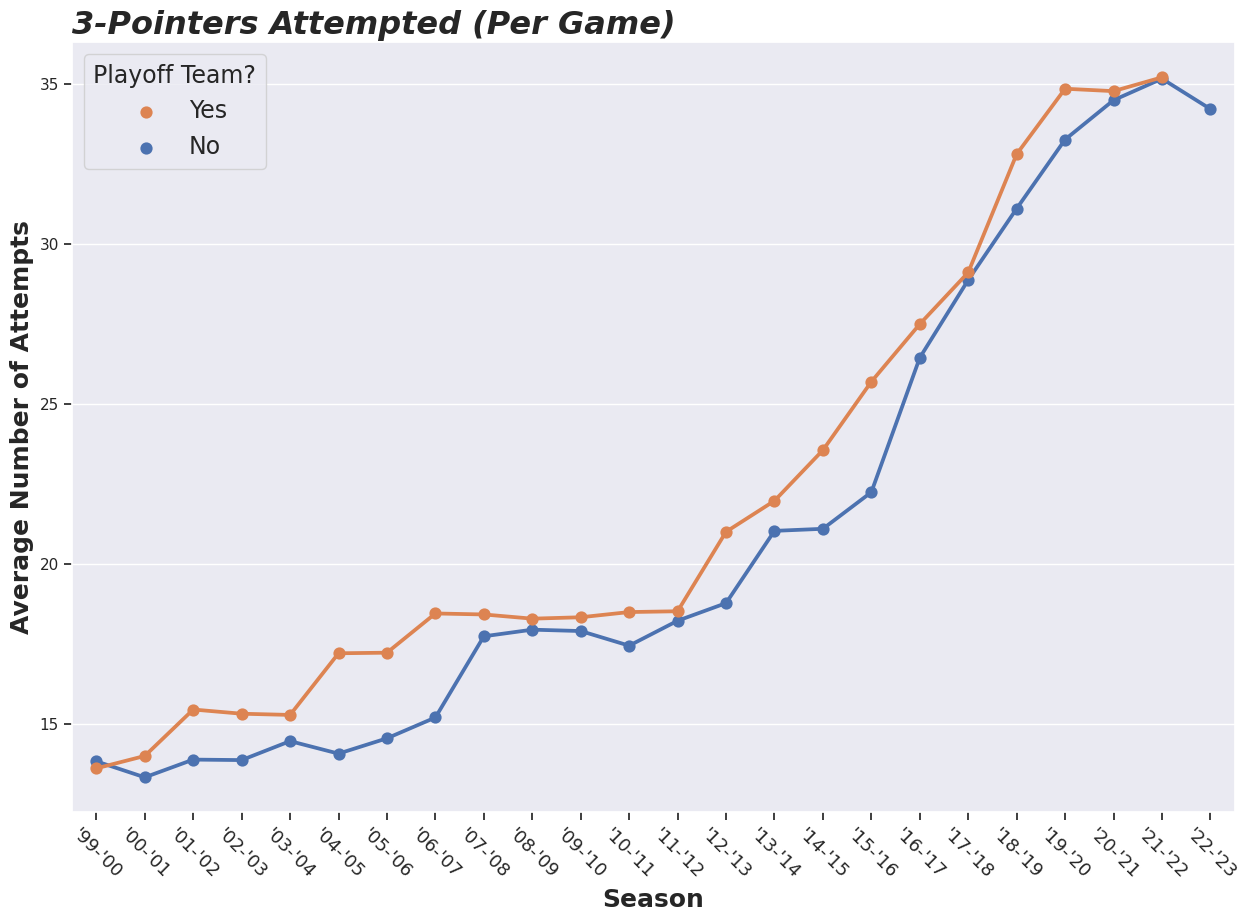

In [12]:
#Setting up the plot
sns.set_theme(style="darkgrid")
sns.set(rc={"figure.figsize":(15, 10)})

#Plotting
ax = sns.pointplot(data=team_totals, 
                   x='season', 
                   y='x3pa_per_game', 
                   hue='playoffs', 
                   errorbar=None)


#Formating the x-labels
ax.set_xticks(range(24))
ax.set_xticklabels(["'99-'00", "'00-'01", "'01-'02", "'02-'03", 
                    "'03-'04", "'04-'05", "'05-'06", "'06-'07", 
                    "'07-'08", "'08-'09", "'09-'10", "'10-'11", 
                    "'11-'12", "'12-'13", "'13-'14", "'14-'15", 
                    "'15-'16", "'16-'17", "'17-'18", "'18-'19", 
                    "'19-'20", "'20-'21", "'21-'22", "'22-'23"], 
                  rotation=-45, size=13)
ax.tick_params(bottom=True, 
               left=True)

#Configuring titles
ax.axes.set_title('3-Pointers Attempted (Per Game)', 
                  fontsize=23, 
                  loc='left', 
                  fontweight='bold', 
                  fontstyle='oblique')
ax.set_xlabel("Season", 
              fontsize=18, 
              fontweight='bold')
ax.set_ylabel("Average Number of Attempts", 
              fontsize=18, 
              fontweight='bold')

#Configuring legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), 
          reversed(["No", "Yes"]), 
          title='Playoff Team?', 
          loc='upper left',
          title_fontsize= 17, 
          fontsize = 17)

From our graph, we see playoffs-making teams continually attempted more 3s than their non-playoff-making counterparts since the beginning of the millennia (even if it's by a small margin).

# 3. ***Shot Mapping***

## 3.1 **Shot Frequency**

To get a better understanding of what was happening on the court we can examine shot location data which gives us the ability to map onto a plane all shots attempted during an entire season.

> **Note:** Due to a majority of basketball shots happening directly under or next to the rim, a maximum cutoff for shots was established when visualizing the entire court so hexbins around the rim would not drown out other hexbins. The maximum cut off chosen was 400 shots.

In [13]:
#THE TEMPLATE OF THIS CODE WAS TAKEN FROM BRADLEY FAY. 
#I'VE ALTERED PARTS OF THE CODE TO WORK WITH THE COORDINATE VALUES IN MY DATASET.

#Drawing basketball court
def draw_court(ax=None, color='white', lw=2, outer_lines=False):
    #If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()
        
    #Create the various parts of an NBA basketball court

    #Create the basketball hoop
    hoop = Circle((0, 55), radius=7.5, linewidth=lw, color="black", fill=False)

    #Create backboard
    backboard = Rectangle((-30, 40), 60, -1, linewidth=lw, color=color)

    #The paint
    outer_box = Rectangle((-80, 0), 160, 190, linewidth=lw, color=color,
                          fill=False)
    #Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, 0), 120, 190, linewidth=lw, color=color,
                          fill=False)

    #Create free throw top arc
    top_free_throw = Arc((0, 190), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    #Create free throw bottom arc
    bottom_free_throw = Arc((0, 190), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    #Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 45), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color="black")

    #Three point line
    #Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, 0), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, 0), 0, 140, linewidth=lw, color=color)
    #3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    #I just played around with the theta values until they lined up with the threes
    three_arc = Arc((0, 50), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    #Center Court
    center_outer_arc = Arc((0, 470), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 470), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    #List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        #Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, 0), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    #Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

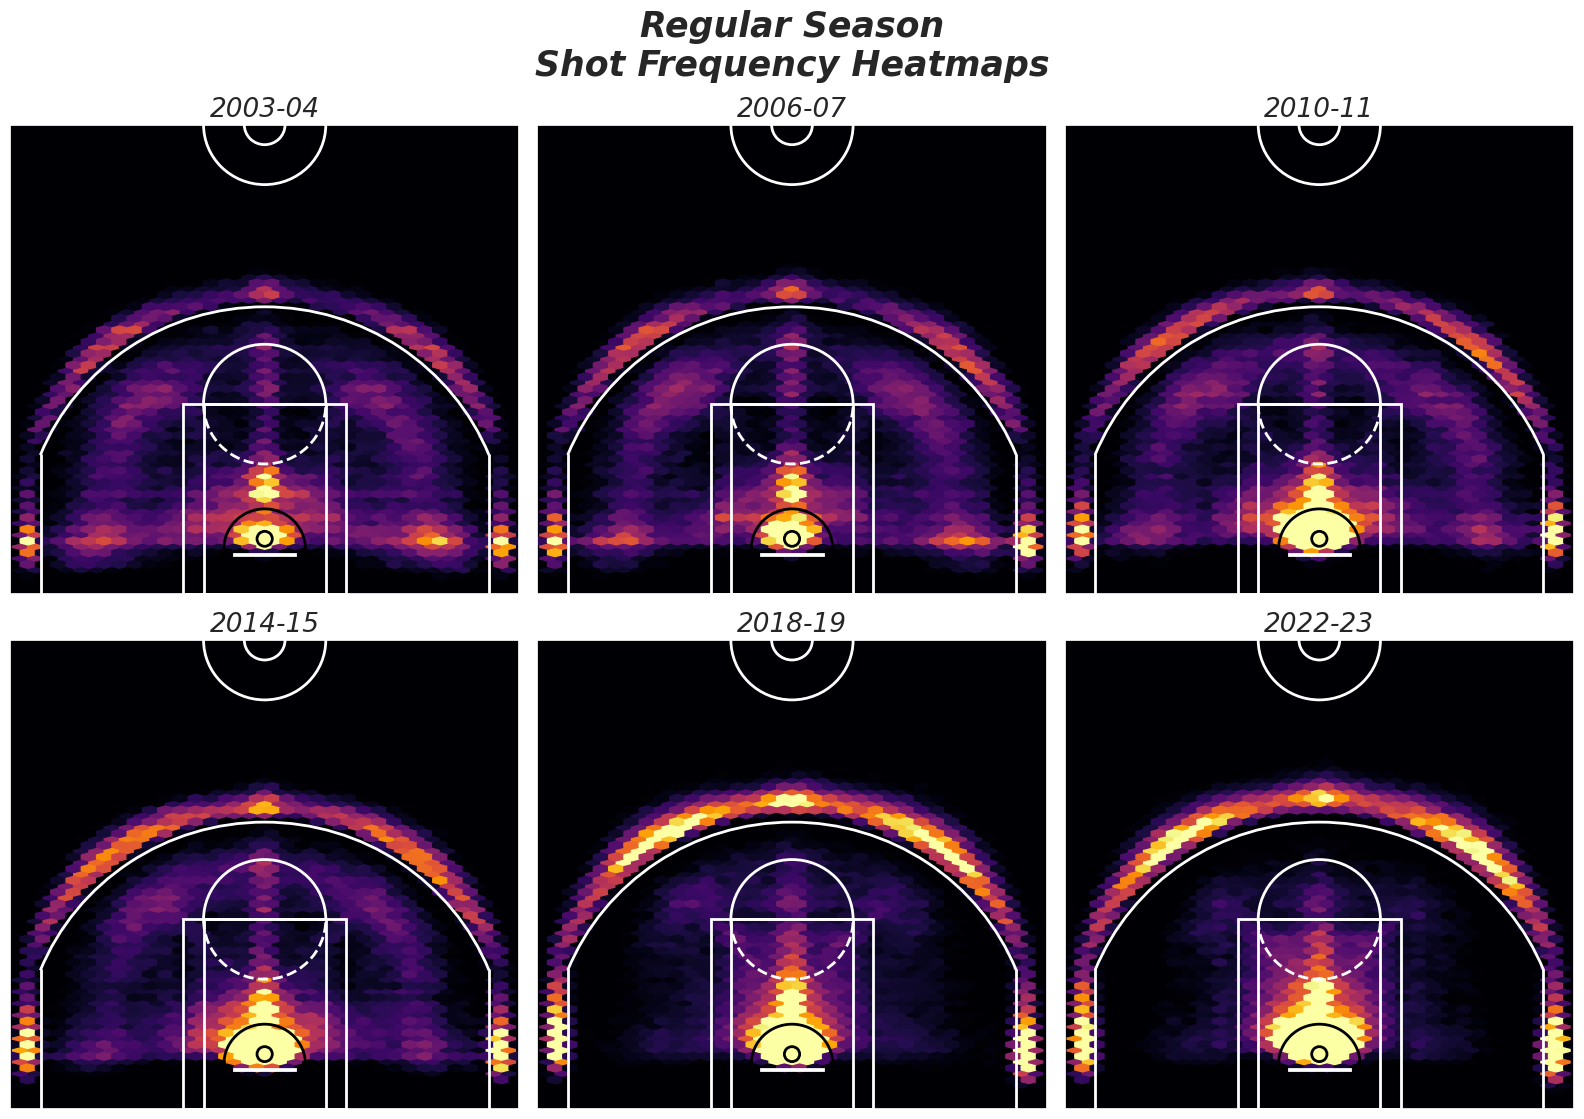

In [14]:
#Setting up plot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,11.4),  sharex=True, sharey=True)
plt.xlim(-250, 250)
plt.ylim(0, 470)


#Ploting each court
#We use larger values than the axis limits to ensure that hexagons go all the way to the boundaries of our draw court           
ax1= ax[0,0].hexbin(shots_04['LOC_X'], 
           shots_04['LOC_Y'], 
           gridsize=(40, 40), 
           extent=(-300, 300, 0, 470), 
           cmap='inferno', 
           vmin=20, 
           vmax=450)

ax2 = ax[0,1].hexbin(shots_07['LOC_X'], 
           shots_07['LOC_Y'], 
           gridsize=(40, 40), 
           extent=(-300, 300, 0, 470), 
           cmap='inferno', 
           vmin=20, 
           vmax=450)

ax3 = ax[0,2].hexbin(shots_11['LOC_X'], 
           shots_11['LOC_Y'], 
           gridsize=(40, 40), 
           extent=(-300, 300, 0, 470), 
           cmap='inferno', 
           vmin=20, 
           vmax=450)

ax4 = ax[1,0].hexbin(shots_15['LOC_X'], 
           shots_15['LOC_Y'], 
           gridsize=(40, 40), 
           extent=(-300, 300, 0, 470), 
           cmap='inferno', 
           vmin=20, 
           vmax=450)

ax5 = ax[1,1].hexbin(shots_19['LOC_X'], 
           shots_19['LOC_Y'], 
           gridsize=(40, 40), 
           extent=(-300, 300, 0, 470), 
           cmap='inferno', 
           vmin=20, 
           vmax=450)

ax6 = ax[1,2].hexbin(shots_23["LOC_X"], 
           shots_23["LOC_Y"], 
           gridsize=(40, 40), 
           extent=(-300, 300, 0, 470), 
           cmap="inferno", 
           vmin=20, 
           vmax=450)

#Add labels to each court image
ax[0, 0].set_title('2003-04', fontsize=19, fontweight='medium', fontstyle='oblique')
ax[0, 1].set_title('2006-07', fontsize=19, fontweight='medium', fontstyle='oblique')
ax[0, 2].set_title('2010-11', fontsize=19, fontweight='medium', fontstyle='oblique')
ax[1, 0].set_title('2014-15', fontsize=19, fontweight='medium', fontstyle='oblique')
ax[1, 1].set_title('2018-19', fontsize=19, fontweight='medium', fontstyle='oblique')
ax[1, 2].set_title('2022-23', fontsize=19, fontweight='medium', fontstyle='oblique')

#Costimizing axis ticks and adding courts
for row in range(2):
    for col in range(3):
        ax[row, col].get_xaxis().set_visible(False)
        ax[row, col].get_yaxis().set_visible(False)
        draw_court(ax[row,col])
        
        
fig.suptitle("Regular Season\nShot Frequency Heatmaps", fontsize=25, fontweight='bold', fontstyle='oblique')
fig.tight_layout()
plt.show()

From charts of the *2003-2004* season to that of *2022-2023* season we see a gradual movement away from the mid-range shot (long 2-pointer) to an increase in 3-pointers as the years went on. Alongside the increase in 3s, there was also an increase in shots concentrating around the ring pointing to a polarity in shot selection for players; in their minds, it's either I shot a 3-Pointer or I take a more efficient/easier shot around the rim.


The death of the midrange (long 2-pointer) shot is clear to see here with the heat map showing shot regions from the *2003-04* season being brighter in the space between the 3-Point line and the key (aka the paint). That brightness/volume shot volume then slowly starts to migrate further and further.

## 3.2 **Shot Distance Distribution**

What interesting things can we discover if we visualize the percentage of shots taken from specific shot distances?

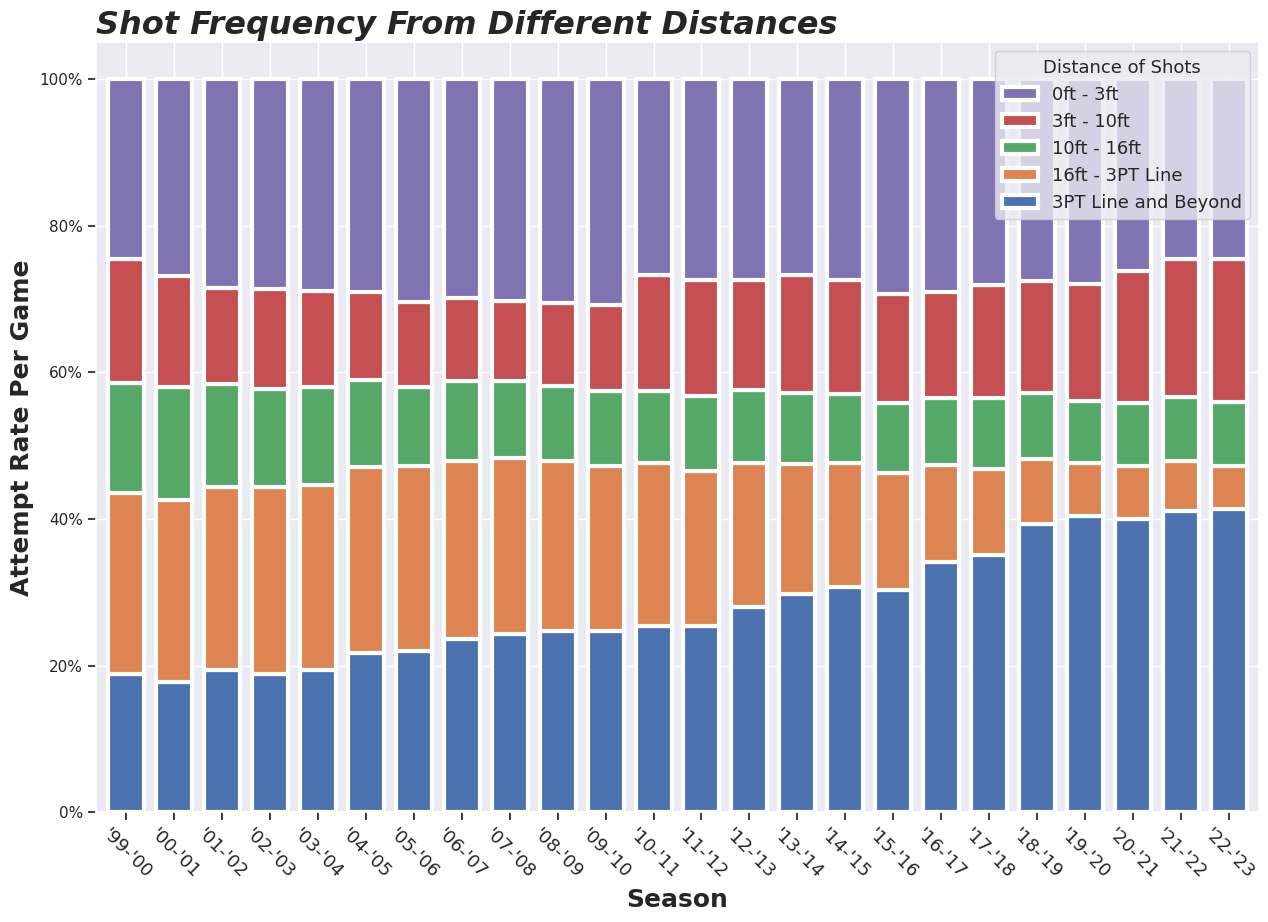

In [15]:
#Setting up the plot
sns.set(rc={"figure.figsize":(15, 10)})
sns.color_palette("tab10")
sns.set(font_scale=1)

attempted = player_shooting.groupby('season')\
            [['percent_fga_from_x3p_range', 'percent_fga_from_x16_3p_range','percent_fga_from_x10_16_range',  'percent_fga_from_x3_10_range', 'percent_fga_from_x0_3_range']]\
            .mean()\
            .reset_index()

#Plotting
ax = attempted.set_index('season').plot(kind='bar', 
                                   stacked=True,  
                                   width = 0.75, 
                                   edgecolor = "white", 
                                   linewidth=3)

#Formating the ylabels to be percentages instead of decimals
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

#Formating the xlabels
ax.set_xticks(range(len(attempted.set_index('season'))))
ax.set_xticklabels(["'99-'00", "'00-'01", "'01-'02", "'02-'03", 
                    "'03-'04", "'04-'05", "'05-'06", "'06-'07", 
                    "'07-'08", "'08-'09", "'09-'10", "'10-'11", 
                    "'11-'12", "'12-'13", "'13-'14", "'14-'15", 
                    "'15-'16", "'16-'17", "'17-'18", "'18-'19", 
                    "'19-'20", "'20-'21", "'21-'22", "'22-'23"], 
                   rotation=-45, 
                   size=13)
ax.tick_params(bottom=True, 
               left=True)

#Configuring titles
ax.axes.set_title('Shot Frequency From Different Distances', 
                  fontsize=23, 
                  loc='left', 
                  fontweight='bold', 
                  fontstyle='oblique')
ax.set_xlabel("Season", 
              fontsize=18, 
              fontweight='bold')
ax.set_ylabel("Attempt Rate Per Game", 
              fontsize=18, 
              fontweight='bold')


#Configuring legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), 
          reversed(["3PT Line and Beyond", "16ft - 3PT Line", "10ft - 16ft", "3ft - 10ft", "0ft - 3ft"]), 
          title='Distance of Shots', 
          loc='upper right',
          title_fontsize= 13,
          fontsize = 13)

Looking into the percentage of shots attempted from certain distances on the court one can see most shot rates from certain distances staying around a similar percentage range while one in particular almost being gone completely. The "16ft to 3-Point line shot (24ft)" is almost going extinct with the boom of the 3-Point shot eating away at shots that would be taken at that distance historically. 

However, the mid-range shot (long 2-pointer) isn't necessarily dead as stars like Kevin Durant, Demar Derozan, and Devin Booker are still known for incorporating such a shot into their shot portfolio.

## 3.3 **Jokić vs Shaq**

The difference in shot selection for players is made even more evident by just looking at the shot selection of the most dominant *Centers* from their respective eras, Shaquille O'Neal and Nikola Jokić.

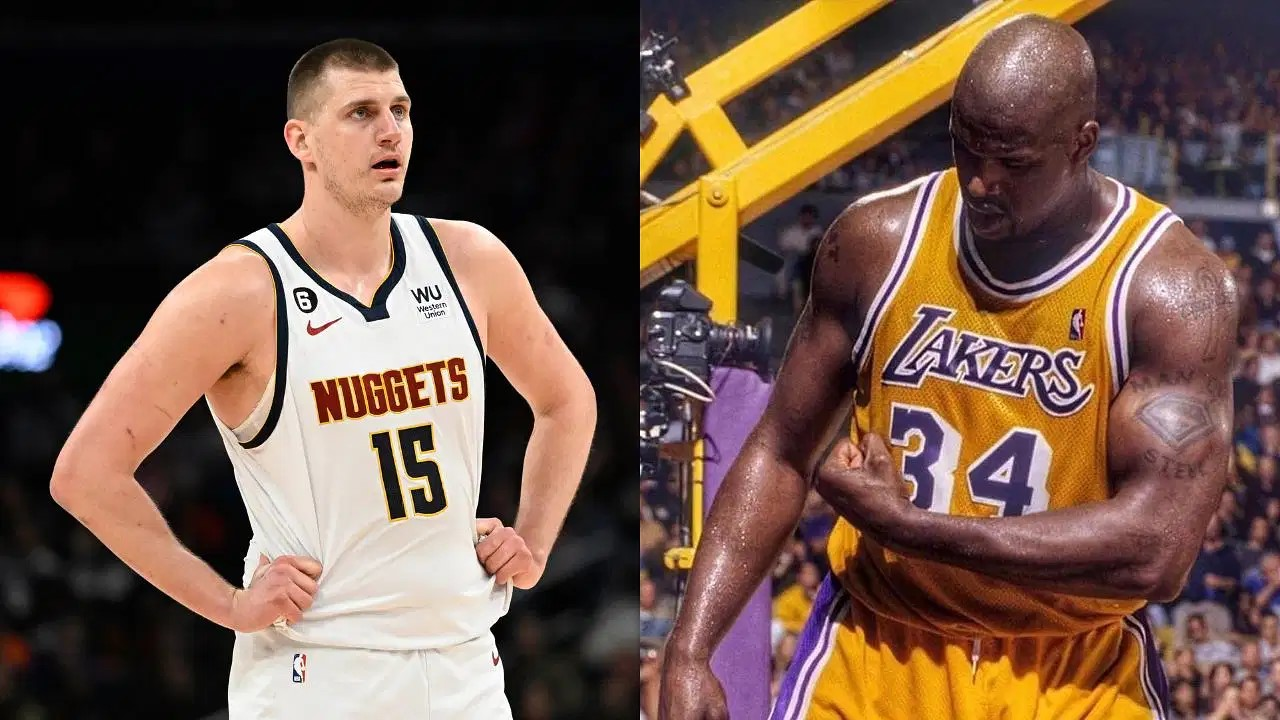

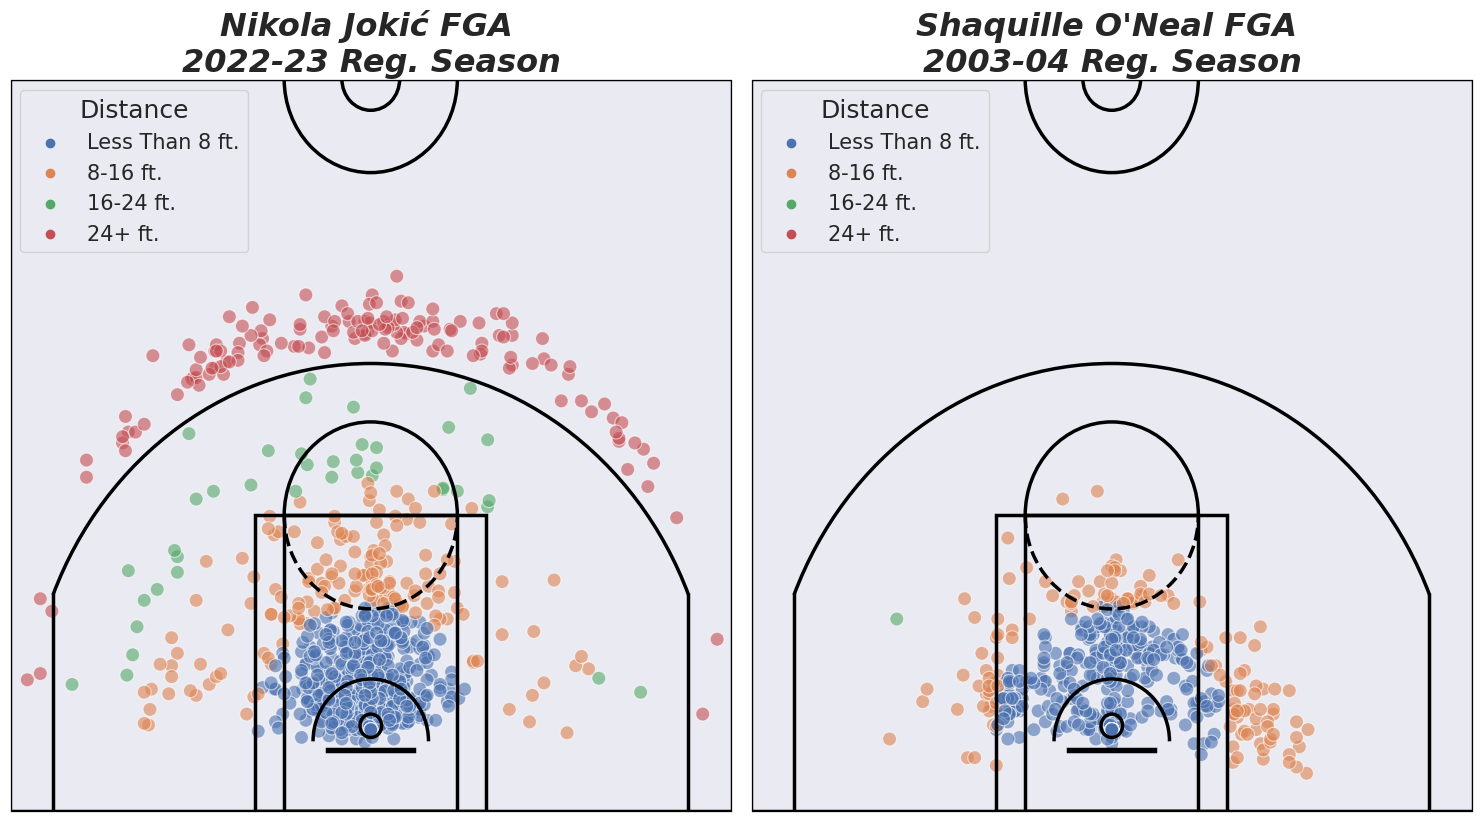

In [16]:
#Creating our two new dataframes
shaq_04 = shots_04.query('PLAYER_ID == 406 & ZONE_RANGE != "Back Court Shot"')
jokic_23 = shots_23.query('PLAYER_NAME == "Nikola Jokic" & ZONE_RANGE != "Back Court Shot"')


#Setting up subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,8.4),  sharex=True, sharey=True)
sns.set_theme(style="dark")


#Ploting our points
sns.scatterplot(data = shaq_04, 
                x='LOC_X', 
                y='LOC_Y',  
                hue='ZONE_RANGE', 
                hue_order=['Less Than 8 ft.', '8-16 ft.', '16-24 ft.', '24+ ft.'], 
                alpha=0.6, 
                s=100,
                ax=ax[1])

sns.scatterplot(data = jokic_23, 
                x='LOC_X', 
                y='LOC_Y',  
                hue='ZONE_RANGE', 
                hue_order=['Less Than 8 ft.', '8-16 ft.', '16-24 ft.', '24+ ft.'], 
                alpha=0.6, 
                s=100,
                ax=ax[0])


#Add labels to each court image
ax[1].set_title("Shaquille O'Neal FGA \n2003-04 Reg. Season", 
                fontsize=23, 
                fontweight='bold', 
                fontstyle='oblique')

ax[0].set_title("Nikola Jokić FGA \n2022-23 Reg. Season", 
                fontsize=23, 
                fontweight='bold', 
                fontstyle='oblique')

#Legends
ax[1].legend(title='Distance',
             loc='upper left',
             title_fontsize= 18,
             fontsize = 15)

ax[0].legend(title='Distance',
             loc='upper left',
             title_fontsize = 18,
             fontsize = 15)

#Costimizing axes
for col in range(2):
    ax[col].get_xaxis().set_visible(False)
    ax[col].get_yaxis().set_visible(False)
    draw_court(ax[col], color='black', outer_lines=True, lw=2.5)

#Dsiplaying plots
fig.tight_layout()
plt.xlim(-250, 251)
plt.ylim(-1, 470)
fig.show()

The singular green dot in Shaq's shot chart illustrates the drastic change in Center's shot selection from the early 2000s to today.

# 4. ***Building a Scouting Report (Past vs Present)***
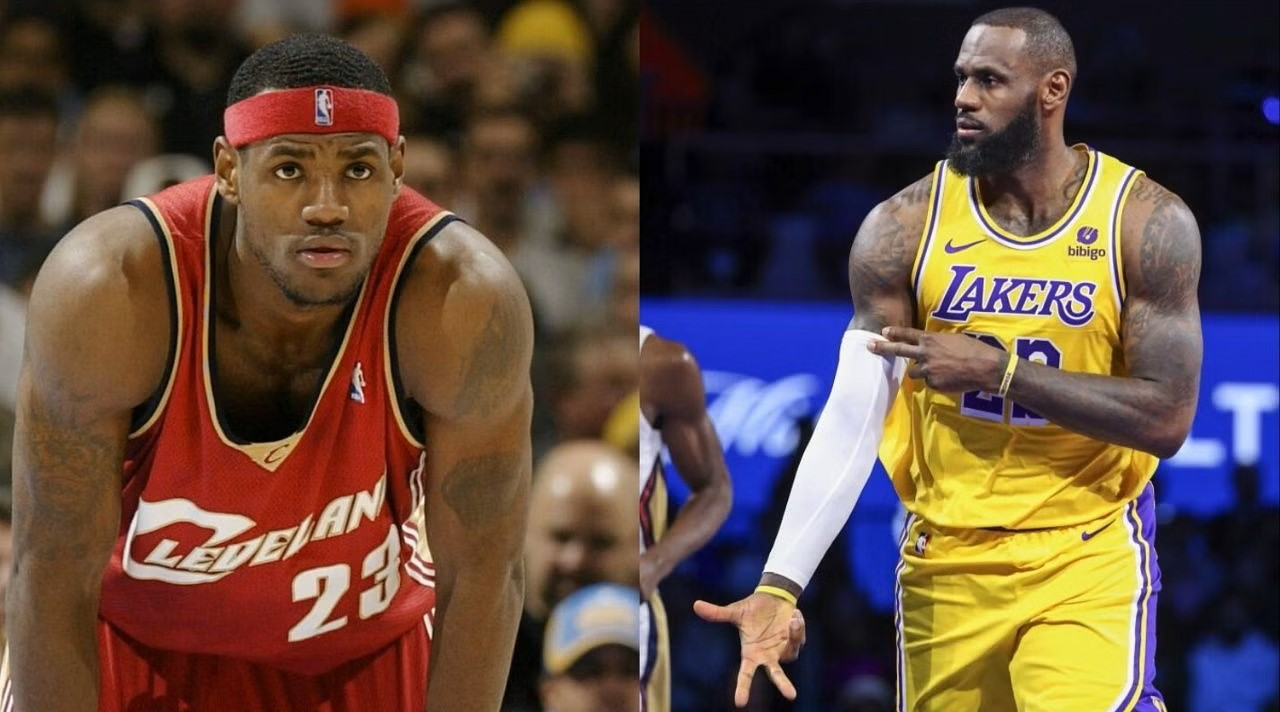
    
Let us take a more granular look at how shooting habits have changed over time by comparing two seasons of Lebron James' career and utilizing machine learning models. Why pick Lebron James for this evaluation? He provides us with a very unique look into a player that still plays at the relatively same pace and efficiency today as he did in the early 2000s when he started his NBA career. Still averaging 25+ points per game in his 21st season he's found ways to evolve his playstyle with the times making him a perfect candidate for our comparison.

## 4.1 **Data Preprocessing**

In [17]:
#Creating our two new dataframes for our ML models
lebron_04 = shots_04.query('PLAYER_NAME == "LeBron James" & ZONE_RANGE != "Back Court Shot"')

#Getting DataFrame ready for preprocessing by removing remaining columns we don't need
lebron04_ml = lebron_04.drop(['SEASON_2', 'TEAM_NAME', 'PLAYER_ID', 'PLAYER_NAME', 'EVENT_TYPE', 
                              'SHOT_TYPE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE', 'BASIC_ZONE', 
                              'ACTION_TYPE','QUARTER', 'MINS_LEFT', 'SECS_LEFT'], 
                             axis=1, 
                             inplace=False)

#Features
X_04 = lebron04_ml.iloc[:, :-1].values
#Labels
y_04 = lebron04_ml.iloc[:, -1].values

#Splitting training set into Train and Test sets
X_train_04, X_test_04, y_train_04, y_test_04 = train_test_split(X_04, y_04, test_size = 0.25, random_state = 42)

#Displaying our new dataset for model training
print("2003-2004 Shooting Dataset")
lebron04_ml

2003-2004 Shooting Dataset


LOC_X  LOC_Y  SHOT_DISTANCE  SHOT_MADE
258      -0.0   52.5              0          1
307      -0.0   52.5              0          0
431     210.0  203.5             25          0
570      -0.0   52.5              0          1
632      -0.0   52.5              0          1
...       ...    ...            ...        ...
189090  -54.0   74.5              5          1
189149  118.0  144.5             14          0
189170 -163.0   57.5             16          1
189202  131.0   54.5             13          1
189240 -158.0   52.5             15          1

[1489 rows x 4 columns]

In [18]:
#Creating our two new dataframes for our ML models
lebron_23 = shots_23.query('PLAYER_NAME == "LeBron James" & ZONE_RANGE != "Back Court Shot"')


#Getting DataFrame ready for preprocessing by removing remaining columns we don't need
lebron23_ml = lebron_23.drop(['SEASON_2', 'TEAM_NAME', 'PLAYER_ID', 'PLAYER_NAME', 'EVENT_TYPE', 
                              'SHOT_TYPE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE', 'BASIC_ZONE', 
                              'ACTION_TYPE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT'], 
                             axis=1, 
                             inplace=False)


#Features
X_23 = lebron23_ml.iloc[:, :-1].values
#Labels
y_23 = lebron23_ml.iloc[:, -1].values

#Splitting training set into Train and Test sets
X_train_23, X_test_23, y_train_23, y_test_23 = train_test_split(X_23, y_23, test_size = 0.25, random_state = 42)

#Displaying our new dataset for model training
print("2023 Shooting Dataset")
lebron23_ml

2023 Shooting Dataset


LOC_X  LOC_Y  SHOT_DISTANCE  SHOT_MADE
116361   37.0  310.5             26          0
116363  -18.0  212.5             16          0
116364   70.0  143.5             11          0
116368   26.0   68.5              3          1
116378 -229.0   65.5             22          0
...       ...    ...            ...        ...
123646   75.0  346.5             30          1
123647  -60.0  336.5             29          0
123649  -20.0  108.5              5          0
123653   29.0  305.5             25          1
123654 -189.0  303.5             31          1

[1219 rows x 4 columns]

## 4.2 **Model Selection and Hyperparameter Tuning**

Let's start the process of building and comparing different classification models with default parameters and then applying more complex tools to make our models more accurate.

Important note that both datasets for each season will be tested on models separately to ensure that the appropriate model is being chosen correctly for each dataset.

### ***2003-2004 Season Dataset: Multi-Model Analysis***

*Training and Performce Metrics w/ Default Parameters*

In [19]:
####################################### MODEL PERFORMANCE 2004 ##################################

#Creating a dictionary of the models we'll be using
class_models = {"Logisitic Regression": LogisticRegression(),
                "Random Forest Classifier": RandomForestClassifier(),
                "K-nearest neighbors": KNeighborsClassifier(),
                "Decision Tree Classifier": DecisionTreeClassifier(),
                "Gradient Boosting Classifier": GradientBoostingClassifier(), 
                "Support Vector Machine": SVC()}

# Train and evaluate each classifier
results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for clf_name, clf in class_models.items():
    # Train the classifier
    clf.fit(X_train_04, y_train_04)
    
    # Make predictions on the test set
    y_pred_04 = clf.predict(X_test_04)

    # Evaluate the classifier
    accuracy = round((accuracy_score(y_test_04, y_pred_04) * 100), 4)
    precision = round((precision_score(y_test_04, y_pred_04) * 100), 4)
    recall = round((recall_score(y_test_04, y_pred_04) * 100), 4)
    f1 = round((f1_score(y_test_04, y_pred_04) * 100), 4)

    # Save results
    results['Model'].append(clf_name)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1 Score'].append(f1)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
results_df.set_index('Model', inplace=True)
results_df.sort_values(by='Accuracy', ascending=False).style.background_gradient(cmap='Blues')

*Feature Importance w/ Default Parameters*

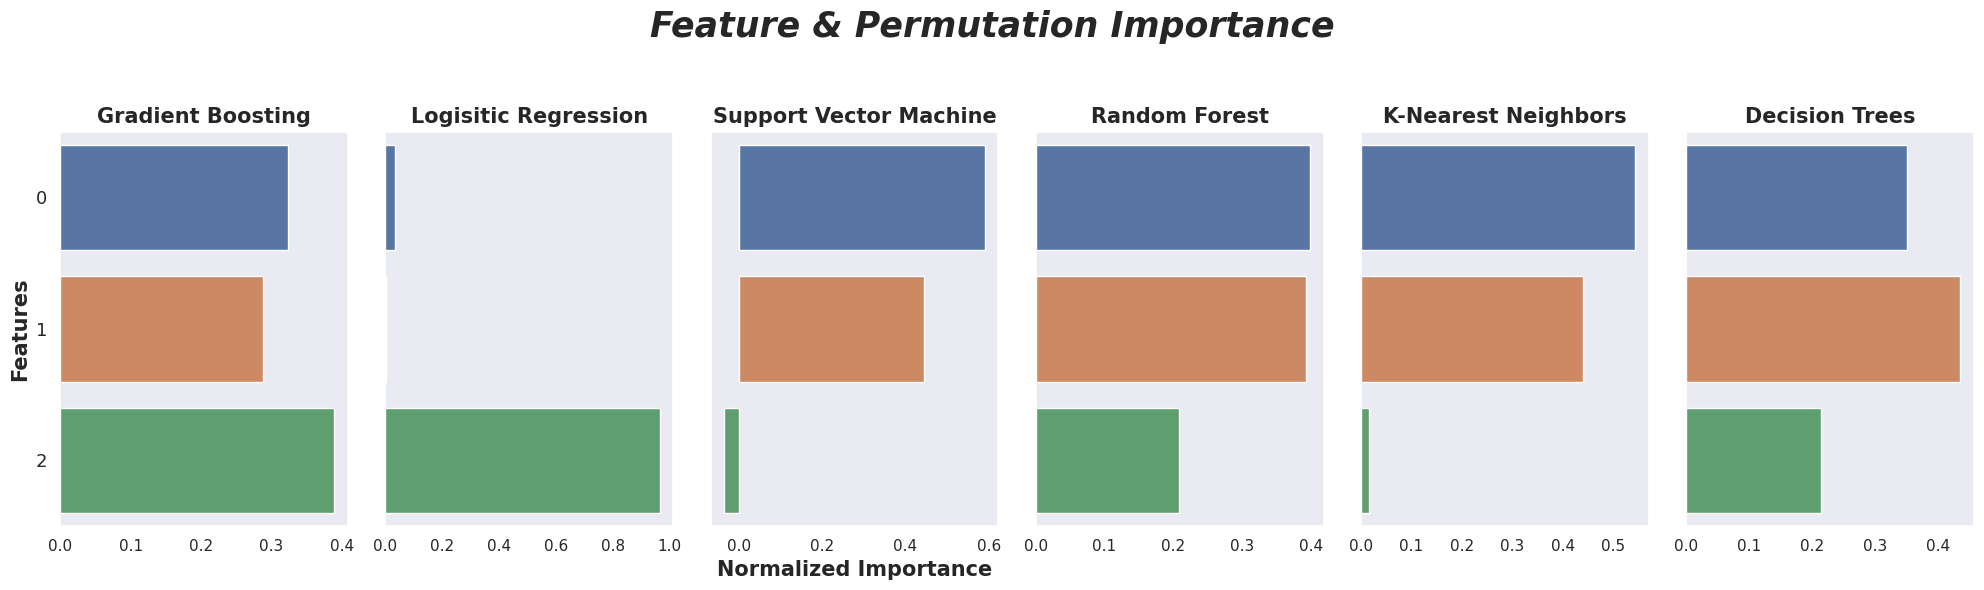

In [20]:
#Convert X_train to a DataFrame with column new names
X_train_df_04 = pd.DataFrame(X_train_04)

X_train_df_04.rename(columns = {"0": "LOC_X", 
                                "1": "LOC_Y", 
                                "2": "SHOT_DISTANCE"}, 
                     inplace = True)   
                             
#Organize classifiers
models = [GradientBoostingClassifier(), 
          LogisticRegression(),
          SVC(),
          RandomForestClassifier(),
          KNeighborsClassifier(),
          DecisionTreeClassifier()]

model_names = ["Gradient Boosting",
               "Logisitic Regression",
               "Support Vector Machine",
               "Random Forest",
               "K-Nearest Neighbors",
               "Decision Trees"]

#Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(20, 6), sharey='row')

#Plot importance for each model
for i, (model, name) in enumerate(zip(models, model_names)):
    model.fit(X_train_04, y_train_04)
    
    #Feature importance for tree-based models (Random Forest, Decision Trees, Gradient Boosting)
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        
    #Feature importance for linear models (Logistic Regression)
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
        
    #Permutation importance for models without feature importance (KNN and SVM)
    else:
        result = permutation_importance(model, X_train_04, y_train_04, n_repeats=10, random_state=42)
        importance = result.importances_mean
        
    #Normalize the importance values for better comparison
    if importance is not None:
       
        importance = importance / np.sum(importance)
    
        #Plot the bar chart
        sns.barplot(x=importance, y=X_train_df_04.columns, ax=axes[i], orient='h')
        
        #Customize x-axis
        axes[i].set_title(f'{name}', fontsize=15, fontweight='bold')
        axes[2].set_xlabel('Normalized Importance', fontsize=15, fontweight='bold')
        
        #Customize y-axis
        axes[i].set_yticks(np.arange(len(importance)))
        axes[i].set_yticklabels(X_train_df_04.columns, rotation=0, fontsize=13)
        axes[0].set_ylabel('Features', fontsize=15, fontweight='bold', ha='center')

#Show plot
fig.suptitle("Feature & Permutation Importance\n", fontsize=25, fontweight='bold', fontstyle='oblique') 
plt.tight_layout()
plt.show()

*Confusion Matrices w/ Default Parameters*

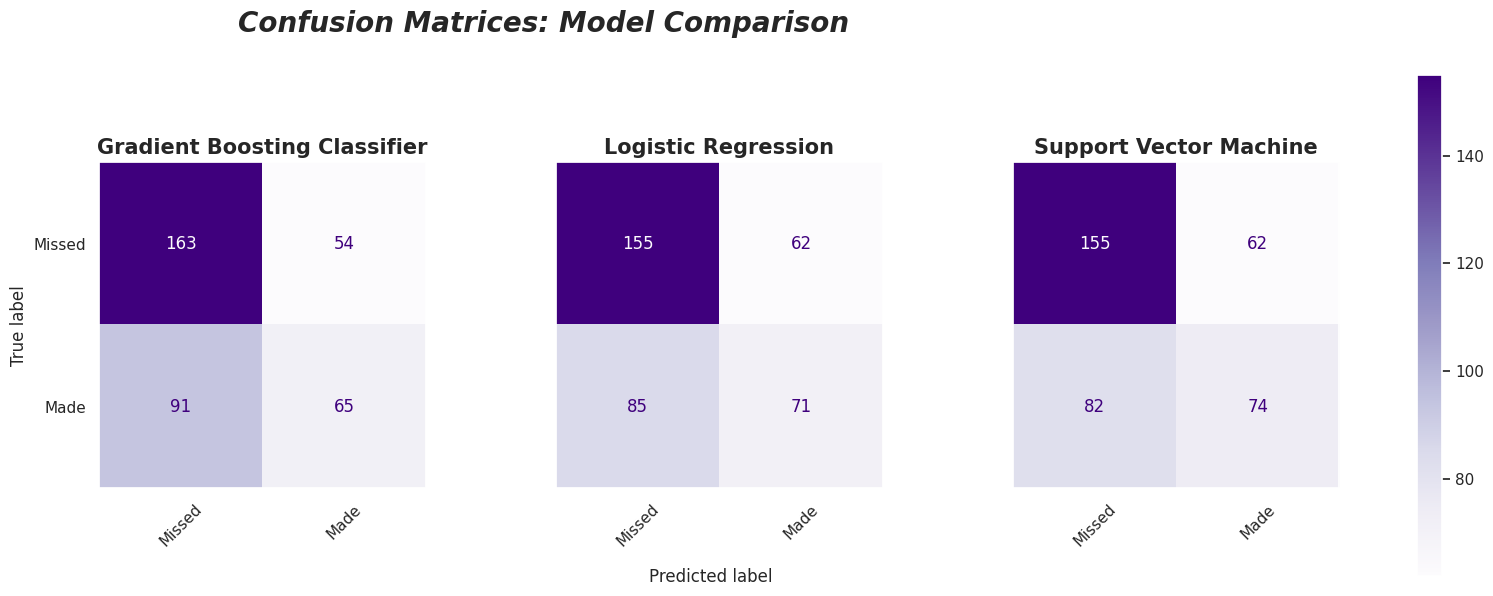

In [21]:
################################ Confusion Matrix 2004 #######################################
#Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6.5), sharey='row')
class_models = {"Gradient Boosting Classifier": GradientBoostingClassifier(),
                "Logistic Regression": LogisticRegression(),
                "Support Vector Machine": SVC()}

#Creating
for i, (key, class_models) in enumerate(class_models.items()):
    y_pred_04 = class_models.fit(X_train_04, y_train_04).predict(X_test_04)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_04, y_pred_04), display_labels=['Missed', 'Made'])
    disp.plot(ax=axes[i], xticks_rotation=45, cmap='Purples')
    disp.ax_.set_title(key, fontsize=15, fontweight='bold')
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

#Displaying plot       
fig.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=1)
fig.suptitle("Confusion Matrices: Model Comparison", fontsize=20, 
             fontweight='bold', fontstyle='oblique', ha='right')
fig.colorbar(disp.im_, ax=axes)
fig.set_tight_layout(False)
fig.show()

*Applying k-Fold Cross Validation*

In [22]:
############################# Applying k-Fold Cross Validation 2004 ####################

#Creating a dictionary of the models we'll be using
class_models = {"Logisitic Regression": LogisticRegression(),
                "Random Forest Classifier": RandomForestClassifier(),
                "K-nearest neighbors": KNeighborsClassifier(),
                "Decision Tree Classifier": DecisionTreeClassifier(),
                "Gradient Boosting Classifier": GradientBoostingClassifier(), 
                "Support Vector Machine": SVC()}

# Train and evaluate each classifier
results = {'Model': [], 'Average Accuracy': [], 'Standard Deviation': []}

for clf_name, clf in class_models.items():
    # Train the classifier
    clf.fit(X_train_04, y_train_04)

    # Evaluate the classifier
    accuracies = cross_val_score(estimator = clf, X = X_train_04, y = y_train_04, cv = 10)
    accuracy = round((accuracies.mean()*100), 4)
    sd = round((accuracies.std()*100), 4)

    # Save results
    results['Model'].append(clf_name)
    results['Average Accuracy'].append(accuracy)
    results['Standard Deviation'].append(sd)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
results_df.set_index('Model', inplace=True)
results_df.sort_values(by='Average Accuracy', ascending=False).style.background_gradient(cmap='Greens')

*Hyperparameter Tuning for our Best performing model (Gradient Boosting)*

In [23]:
############################# Using GridSearchCV ####################

#Define the parameter grid for GridSearchCV
param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth': [3, 5, 7]}

#Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier()
 
#Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)
 
#Fit the model to the training data using GridSearchCV
grid_search.fit(X_train_04, y_train_04)
 
#Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
 
#Make predictions on the test set using the best model
y_pred_best_04 = best_model.predict(X_test_04)
 
#Evaluate the best model
accuracy_best = accuracy_score(y_test_04, y_pred_best_04)
 
#Print results
print("Best Parameters (Grid Search):", best_params)
print(f"Best Model Accuracy (Grid Search): {accuracy_best}")

Best Parameters (Grid Search): {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best Model Accuracy (Grid Search): 0.6353887399463807


### ***2022-2023 Season Dataset: Model Analysis***

*Training and Performce Metrics w/ Default Parameters*

In [24]:
####################################### MODEL PERFORMANCE 2023 ##################################

#Creating a dictionary of the models we'll be using
class_models = {"Logisitic Regression": LogisticRegression(),
                "Random Forest Classifier": RandomForestClassifier(),
                "K-nearest neighbors": KNeighborsClassifier(),
                "Decision Tree Classifier": DecisionTreeClassifier(),
                "Gradient Boosting Classifier": GradientBoostingClassifier(), 
                "Support Vector Machine": SVC()}

# Train and evaluate each classifier
results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for clf_name, clf in class_models.items():
    # Train the classifier
    clf.fit(X_train_23, y_train_23)
    
    # Make predictions on the test set
    y_pred_23 = clf.predict(X_test_23)

    # Evaluate the classifier
    accuracy = round((accuracy_score(y_test_23, y_pred_23) * 100), 4)
    precision = round((precision_score(y_test_23, y_pred_23) * 100), 4)
    recall = round((recall_score(y_test_23, y_pred_23) * 100), 4)
    f1 = round((f1_score(y_test_23, y_pred_23) * 100), 4)

    # Save results
    results['Model'].append(clf_name)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1 Score'].append(f1)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
results_df.set_index('Model', inplace=True)
results_df.sort_values(by='Accuracy', ascending=False).style.background_gradient(cmap='Blues')

*Feature Importance w/ Default Parameters*

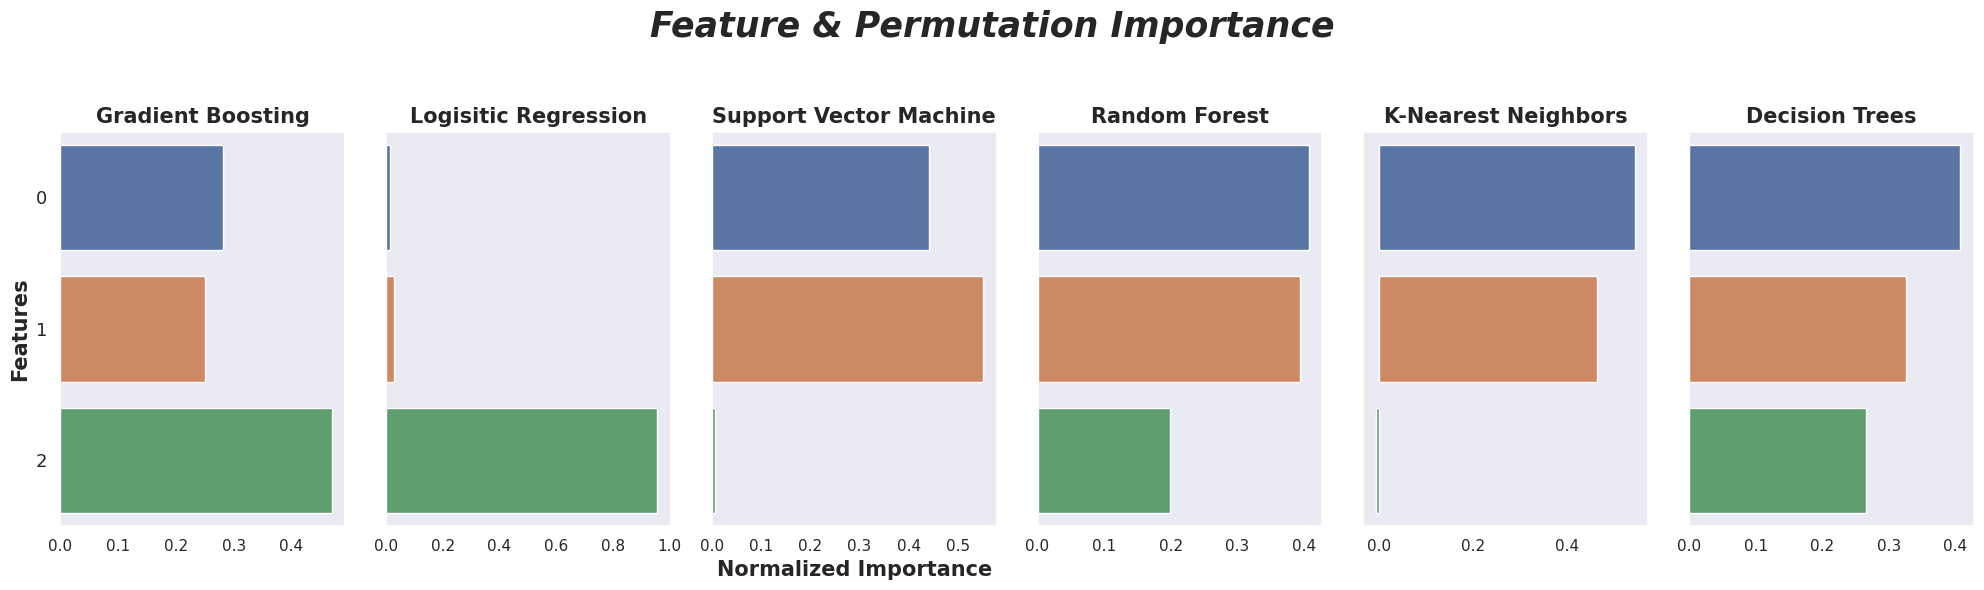

In [25]:
#Convert X_train to a DataFrame with column new names
X_train_df_23 = pd.DataFrame(X_train_23)

X_train_df_23.rename(columns = {"0": "LOC_X", 
                                "1": "LOC_Y", 
                                "2": "SHOT_DISTANCE"}, 
                     inplace = True)  
                             
#Organize classifiers
models = [GradientBoostingClassifier(), 
          LogisticRegression(),
          SVC(),
          RandomForestClassifier(),
          KNeighborsClassifier(),
          DecisionTreeClassifier()]

model_names = ["Gradient Boosting",
               "Logisitic Regression",
               "Support Vector Machine",
               "Random Forest",
               "K-Nearest Neighbors",
               "Decision Trees"]

#Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(20, 6), sharey='row')

#Plot importance for each model
for i, (model, name) in enumerate(zip(models, model_names)):
    model.fit(X_train_23, y_train_23)
    
    #Feature importance for tree-based models (Random Forest, Decision Trees, Gradient Boosting)
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        
    #Feature importance for linear models (Logistic Regression)
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
        
    #Permutation importance for models without feature importance (KNN and SVM)
    else:
        result = permutation_importance(model, X_train_23, y_train_23, n_repeats=10, random_state=42)
        importance = result.importances_mean
        
    #Normalize the importance values for better comparison
    if importance is not None:
       
        importance = importance / np.sum(importance)
    
        #Plot the bar chart
        sns.barplot(x=importance, y=X_train_df_23.columns, ax=axes[i], orient='h')
        
        #Customize x-axis
        axes[i].set_title(f'{name}', fontsize=15, fontweight='bold')
        axes[2].set_xlabel('Normalized Importance', fontsize=15, fontweight='bold')
        
        #Customize y-axis
        axes[i].set_yticks(np.arange(len(importance)))
        axes[i].set_yticklabels(X_train_df_23.columns, rotation=0, fontsize=13, ha='right')
        axes[0].set_ylabel('Features', fontsize=15, fontweight='bold', ha='center')

#Show plot
fig.suptitle("Feature & Permutation Importance\n", fontsize=25, fontweight='bold', fontstyle='oblique') 
plt.tight_layout()
plt.show()

*Comparison Matrices w/ Default Parameters*

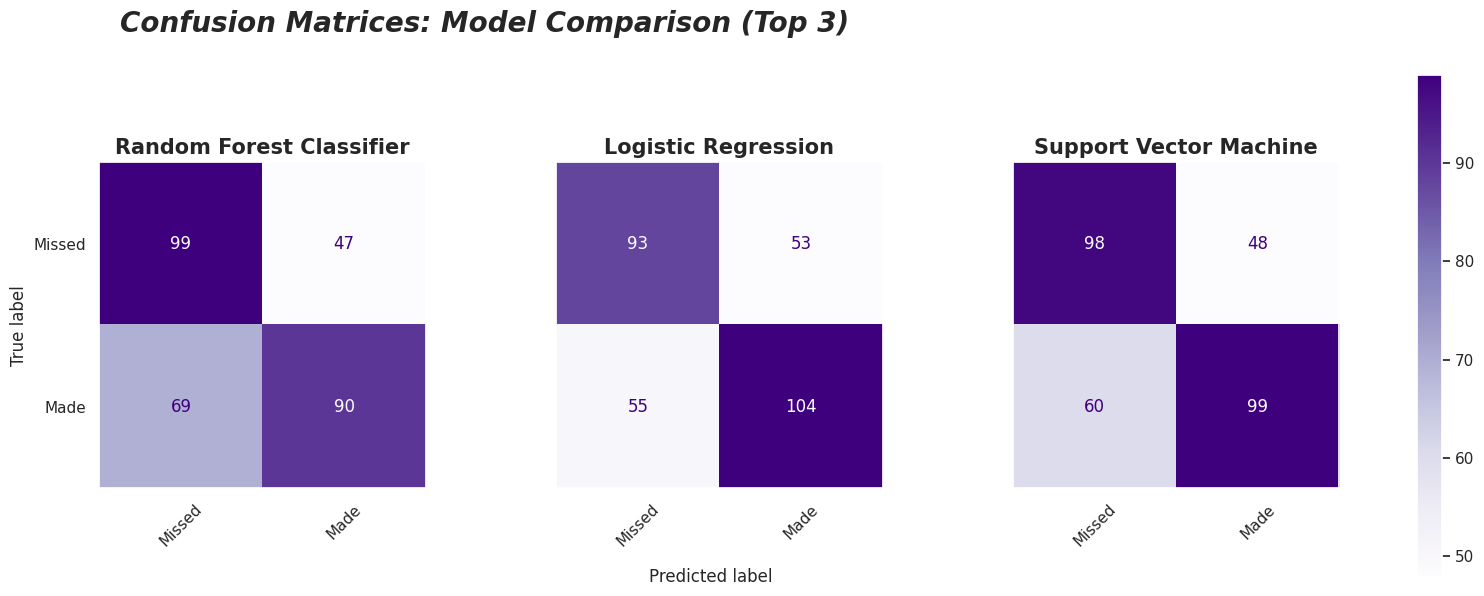

In [26]:
################################ Confusion Matrix 2023 #######################################

#Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6.5), sharey='row')
class_models = {"Random Forest Classifier": RandomForestClassifier(),
                "Logistic Regression": LogisticRegression(class_weight='balanced'),
                "Support Vector Machine": SVC()}

#https://stackoverflow.com/questions/61825227/plotting-multiple-confusion-matrix-side-by-side
for i, (key, class_models) in enumerate(class_models.items()):
    y_pred_23 = class_models.fit(X_train_23, y_train_23).predict(X_test_23)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_23, y_pred_23), display_labels=['Missed', 'Made'])
    disp.plot(ax=axes[i], xticks_rotation=45, cmap='Purples')
    disp.ax_.set_title(key, fontsize=15, fontweight='bold')
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

#Displaying plot       
fig.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=1)
fig.suptitle("Confusion Matrices: Model Comparison (Top 3)", fontsize=20, fontweight='bold', fontstyle='oblique', ha='right')
fig.colorbar(disp.im_, ax=axes)
fig.set_tight_layout(False)
fig.show()

*Applying k-Fold Cross Validation*

In [27]:
############################# Applying k-Fold Cross Validation 2023 ####################

#Creating a dictionary of the models we'll be using
class_models = {"Logisitic Regression": LogisticRegression(),
                "Random Forest Classifier": RandomForestClassifier(),
                "K-nearest neighbors": KNeighborsClassifier(),
                "Decision Tree Classifier": DecisionTreeClassifier(),
                "Gradient Boosting Classifier": GradientBoostingClassifier(), 
                "Support Vector Machine": SVC()}

# Train and evaluate each classifier
results = {'Model': [], 'Average Accuracy': [], 'Standard Deviation': []}

for clf_name, clf in class_models.items():
    # Train the classifier
    clf.fit(X_train_23, y_train_23)

    # Evaluate the classifier
    accuracies = cross_val_score(estimator = clf, X = X_train_23, y = y_train_23, cv = 10)
    accuracy = round((accuracies.mean()*100), 4)
    sd = round((accuracies.std()*100), 4)

    # Save results
    results['Model'].append(clf_name)
    results['Average Accuracy'].append(accuracy)
    results['Standard Deviation'].append(sd)

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
results_df.set_index('Model', inplace=True)
results_df.sort_values(by='Average Accuracy', ascending=False).style.background_gradient(cmap='Greens')

*Hyperparameter Tuning for our Best Performing Model*

In [28]:
############################# Using GridSearchCV ####################
#Define the parameter grid for GridSearchCV
param_grid = {'n_estimators': [50, 100, 200],
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth': [3, 5, 7]}

#Run the Gradient Boosting model
gb_model = GradientBoostingClassifier()
 
#Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)
 
#Fit the model to the training data using GridSearchCV
grid_search.fit(X_train_23, y_train_23)
 
#Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
 
#Make predictions on the test set using the best model
y_pred_best_23 = best_model.predict(X_test_23)
 
#Evaluate the best model
accuracy_best = accuracy_score(y_test_23, y_pred_best_23)
 
#Print results
print("Best Parameters (Grid Search):", best_params)
print(f"Best Model Accuracy (Grid Search): {accuracy_best}")

Best Parameters (Grid Search): {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Best Model Accuracy (Grid Search): 0.6721311475409836


Gradient Boosted Trees is the model we'll use for both data sets as it boasts the highest Accuracy and Precision score after tuning all the classification models tested. It's important as well to point out feature importance with how Gradient Boosting and Random Forest both hold shot coordinate features 'LOC_X' and 'LOC_Y' at a much higher relevance than Logistic Regression which holds 'SHOT_DISTANCE' as the most important features in its prediction model.

## 4.3 **Lebron 2004**

<Figure size 1500x940 with 0 Axes>

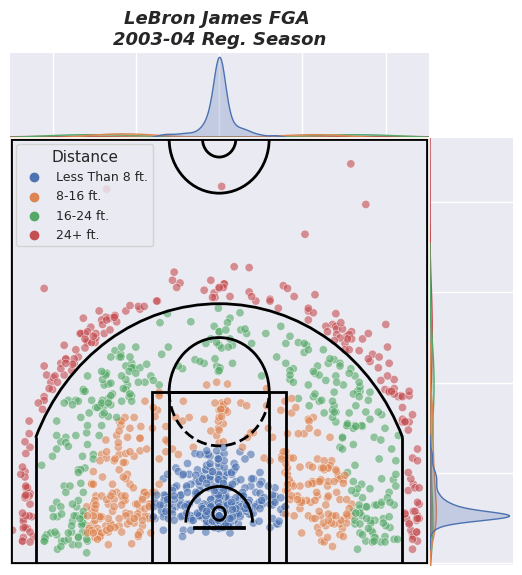

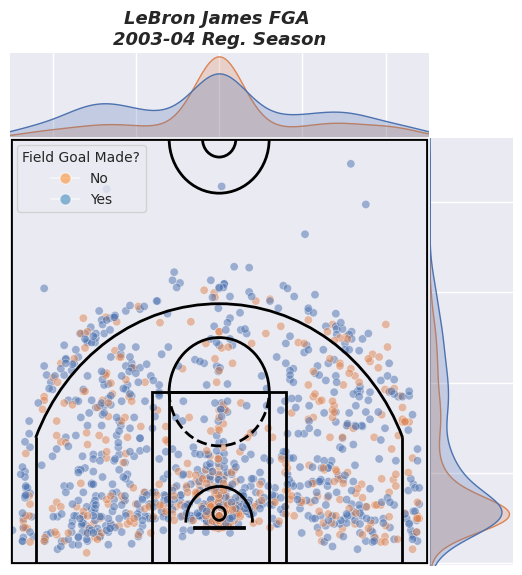

In [29]:
#Setting up seaborn plot
plt.figure(figsize=(15,9.4))
sns.set_theme(style="darkgrid")
sns.set_color_codes()


#################################### DISTANCE #########################################
#Plotting
ax = sns.jointplot(data = lebron_04, 
                   x='LOC_X', 
                   y='LOC_Y', 
                   kind='scatter', 
                   hue='ZONE_RANGE', 
                   hue_order=['Less Than 8 ft.', '8-16 ft.', '16-24 ft.', '24+ ft.'], 
                   space=0, 
                   alpha=0.6)


#Court and axes
draw_court(outer_lines=True, color="black")
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.xlim(-251, 252)
plt.ylim(-2, 471)

#Title
plt.title('LeBron James FGA \n2003-04 Reg. Season', 
          fontsize=13,
          loc='center',
          fontweight='bold',
          y=1.2, 
          fontstyle='oblique')

#Legend
plt.legend(title='Distance',
          loc='upper left',
          title_fontsize= 11,
          fontsize = 9)

################################## FIELD GOAL MADE? #####################################
#Plotting
g = sns.jointplot(data = lebron_04, 
                  x='LOC_X', 
                  y='LOC_Y', 
                  kind='scatter',
                  hue='SHOT_MADE',
                  space=0, 
                  alpha=0.5)

#Court and axes
draw_court(outer_lines=True, color="black")
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.xlim(-251, 252)
plt.ylim(-2, 471)

#Title
plt.title('LeBron James FGA \n2003-04 Reg. Season', 
          fontsize=13,
          loc='center',
          fontweight='bold',
          y=1.2, 
          fontstyle='oblique')

from matplotlib.lines import Line2D
#Legend
legend_labels = [Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:orange', markersize=8, alpha=0.5, label='No'),
                 Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', markersize=8, alpha=0.5,  label='Yes')]
g.ax_joint.legend(handles=legend_labels, title='Field Goal Made?', loc='upper left', title_fontsize=10, fontsize=10)


plt.show()

Now using our Gradient Boosted model let's looks at a kdeplot for location mapping to get a better picture of how Lebron's shooting habits and hotpots.

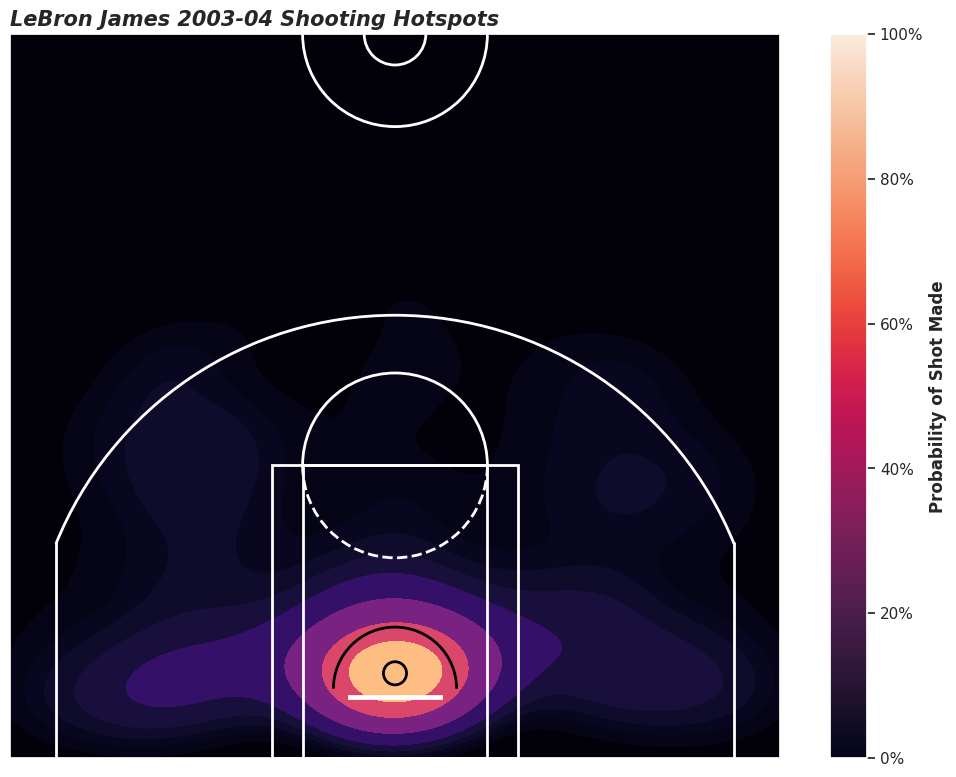

In [30]:
#Player data
X = lebron04_ml.iloc[:, :-1].values
y = lebron04_ml.iloc[:, -1].values

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Training Gradient Boosting Classifier
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=3)
gb.fit(X_train, y_train)

#Probabilities for each shot
lebron04_ml['shot_probability'] = gb.predict_proba(lebron04_ml.iloc[:, :-1].values)[:, 1]

#Basketball court and shooting hotspots using KDE contour plot
def plot_shooting_hotspots(data):
    #Plotting basketball court
    plt.figure(figsize=(13, 9.4))
    sns.set_theme(style="darkgrid")
    
    #KDE contour plot
    ax = sns.kdeplot(x=data["LOC_X"], y=data["LOC_Y"], fill=True, cmap="magma", levels=10, thresh=0, common_norm=False)
    
    #Colorbar with percentage labels
    cbar = plt.colorbar(ax.collections[0], label='Shooting Probability', format=FuncFormatter(lambda x, _: f'{int(x*100)}%'))

    plt.title('LeBron James 2003-04 Shooting Hotspots', fontsize=15, fontweight='bold', fontstyle='oblique', loc='left')
    plt.xticks([])  
    plt.yticks([]) 
    draw_court(outer_lines=False, color="white", lw=2)
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)
    plt.xlim(-250, 250)
    plt.ylim(0, 470)
    plt.gca().set_aspect('equal', adjustable='box')  # Keep the court aspect ratio

    #Adjust the colorbar position if needed
    cbar.set_label('Probability of Shot Made', fontweight='bold')
    plt.show()

#Shooting hotspots on the court
plot_shooting_hotspots(lebron04_ml)

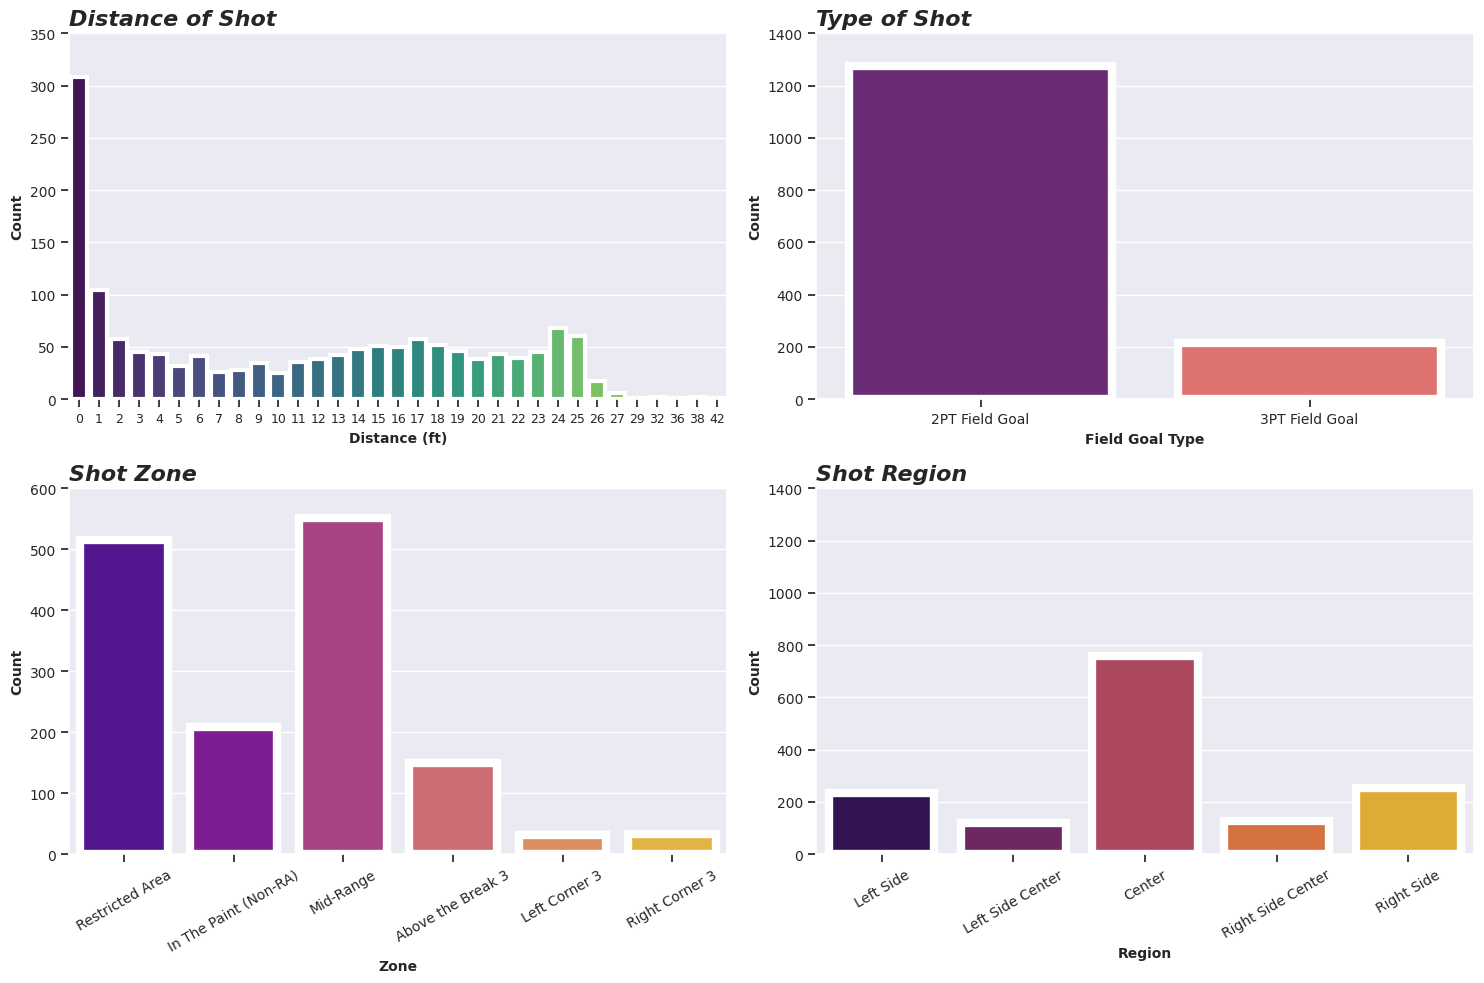

In [31]:
#Setting up subplots
fig, ax = plt.subplots(nrows=2, ncols=2)
sns.set_theme(style="darkgrid")

#Defining our Dataframe
df=lebron_04

#Plot 1
sns.countplot(x="SHOT_DISTANCE", data=df, ax=ax[0, 0], palette='viridis', edgecolor = "white", linewidth=3)
ax[0, 0].set_title('Distance of Shot', fontweight='bold', fontstyle='oblique', loc="left", size=16)
ax[0, 0].set_xlabel('Distance (ft)', size=10, fontweight='bold')
ax[0, 0].set_ylabel('Count', size=10, fontweight='bold')
ax[0, 0].set_xticks(ax[0, 0].get_xticks())
ax[0, 0].set_yticks(ax[0, 0].get_yticks())
ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=0, ha='center', size=9)
ax[0, 0].set_yticklabels(ax[0, 0].get_yticklabels(), rotation=0, ha='right', size=10)
ax[0, 0].tick_params(bottom=True, left=True)

#Plot 2
sns.countplot(x="SHOT_TYPE", data=df, ax=ax[0, 1], palette='magma', edgecolor = "white", linewidth=6, 
              order=['2PT Field Goal', '3PT Field Goal'])
ax[0, 1].set_title('Type of Shot', fontweight='bold', fontstyle='oblique', loc="left", size=16)
ax[0, 1].set_xlabel('Field Goal Type', size=10, fontweight='bold')
ax[0, 1].set_ylabel('Count', size=10, fontweight='bold')
ax[0, 1].set_xticks(ax[0, 1].get_xticks())
ax[0, 1].set_yticks(ax[0, 1].get_yticks())
ax[0, 1].set_xticklabels(ax[0, 1].get_xticklabels(), rotation=0, ha='center', size=10)
ax[0, 1].set_yticklabels(ax[0, 1].get_yticklabels(), rotation=0, ha='right', size=10)
ax[0, 1].tick_params(bottom=True, left=True)

#Plot 3
sns.countplot(x="BASIC_ZONE", data=df, ax=ax[1, 0], palette='plasma',edgecolor = "white", linewidth=6,
              order=['Restricted Area', 'In The Paint (Non-RA)', 'Mid-Range','Above the Break 3', 'Left Corner 3', 'Right Corner 3'])
ax[1, 0].set_title('Shot Zone', fontweight='bold', fontstyle='oblique', loc="left", size=16)
ax[1, 0].set_xlabel('Zone', size=10, fontweight='bold')
ax[1, 0].set_ylabel('Count', size=10, fontweight='bold')
ax[1, 0].set_xticks(ax[1, 0].get_xticks())
ax[1, 0].set_yticks(ax[1, 0].get_yticks())
ax[1, 0].set_xticklabels(ax[1, 0].get_xticklabels(), rotation=30, ha='center', size=10)
ax[1, 0].set_yticklabels(ax[1, 0].get_yticklabels(), rotation=0, ha='right', size=10)
ax[1, 0].tick_params(bottom=True, left=True)

#Plot 4
sns.countplot(x="ZONE_NAME", data=df, ax=ax[1, 1], palette='inferno', edgecolor = "white", linewidth=6, 
              order=['Left Side', 'Left Side Center', 'Center', 'Right Side Center', 'Right Side'])
ax[1, 1].set_title('Shot Region', fontweight='bold', fontstyle='oblique', loc="left", size=16)
ax[1, 1].set_xlabel('Region', size=10, fontweight='bold')
ax[1, 1].set_ylabel('Count', size=10, fontweight='bold')
ax[1, 1].set_xticks(ax[1, 1].get_xticks())
ax[1, 1].set_yticks(ax[0, 1].get_yticks())
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=30, ha='center', size=10)
ax[1, 1].set_yticklabels(ax[1, 1].get_yticklabels(), rotation=0, ha='right', size=10)
ax[1, 1].tick_params(bottom=True, left=True)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Coaches during and after the *2003-04* season would evaluate LeBron's shot diet as that of a strong finisher at the rim with a deadly baseline jump shot from both left and right. These findings indicate optimal defensive locations to guard LeBron due to his success in those regions.

## 4.4 **Lebron 2023**

<Figure size 1500x940 with 0 Axes>

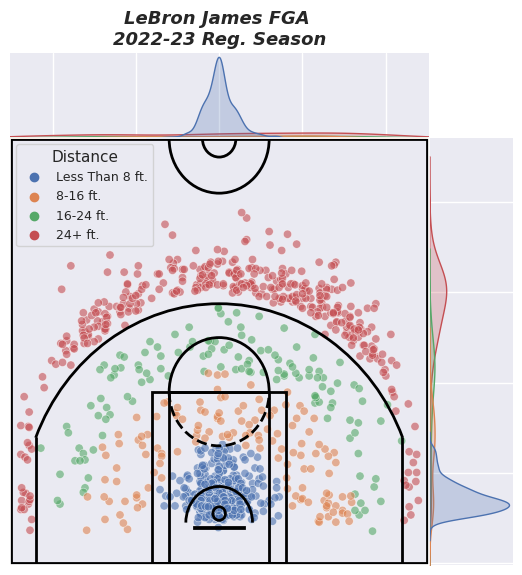

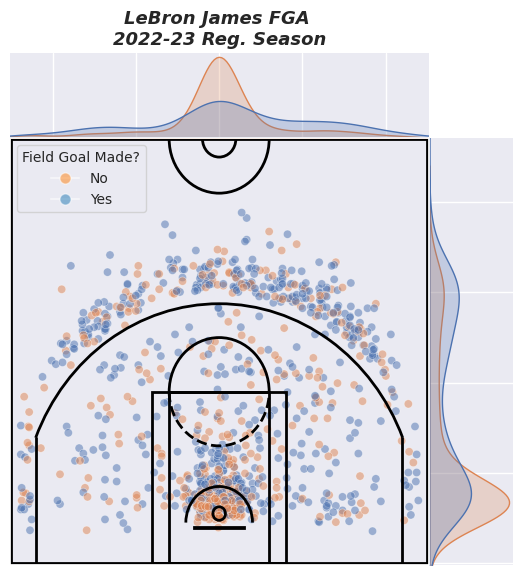

In [32]:
plt.figure(figsize=(15,9.4))
sns.set_theme(style="darkgrid")
sns.set_color_codes()

#################################### DISTANCE #########################################
#Plotting
sns.jointplot(data = lebron_23, 
              x='LOC_X', 
              y='LOC_Y', 
              kind='scatter', 
              hue='ZONE_RANGE', 
              hue_order=['Less Than 8 ft.', '8-16 ft.', '16-24 ft.', '24+ ft.'],
              space=0, 
              alpha=0.6)

#Court and axis
draw_court(outer_lines=True, color="black")
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.xlim(-251, 252)
plt.ylim(-2, 471)

#Title
plt.title('LeBron James FGA \n2022-23 Reg. Season', 
          fontsize=13,
          loc='center',
          fontweight='bold',
          y=1.2, 
          fontstyle='oblique')

#Legend
plt.legend(title='Distance',
          loc='upper left',
          title_fontsize= 11,
          fontsize = 9)

################################## FIELD GOAL MADE? ####################################
#Plotting
g = sns.jointplot(data = lebron_23, 
                  x='LOC_X', 
                  y='LOC_Y', 
                  kind='scatter',
                  hue='SHOT_MADE',
                  space=0, 
                  alpha=0.5, 
                  legend=False)

#Court and axes
draw_court(outer_lines=True, color="black")
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.xlim(-251, 252)
plt.ylim(-2, 471)

#Title
plt.title('LeBron James FGA \n2022-23 Reg. Season', 
          fontsize=13,
          loc='center',
          fontweight='bold',
          y=1.2, 
          fontstyle='oblique')

#Legend
legend_labels = [Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:orange', markersize=8, alpha=0.5, label='No'),
                 Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', markersize=8, alpha=0.5,  label='Yes')]
g.ax_joint.legend(handles=legend_labels, title='Field Goal Made?', loc='upper left', title_fontsize=10, fontsize=10)

       
plt.show()

We see a clear difference in Lebron's shooting habits with the distribution graph on the right showing us a higher volume of 3-Pointers (24+ft) shot by Lebron in the *2022-23* season in comparison to his rookie season in *2003-04*.

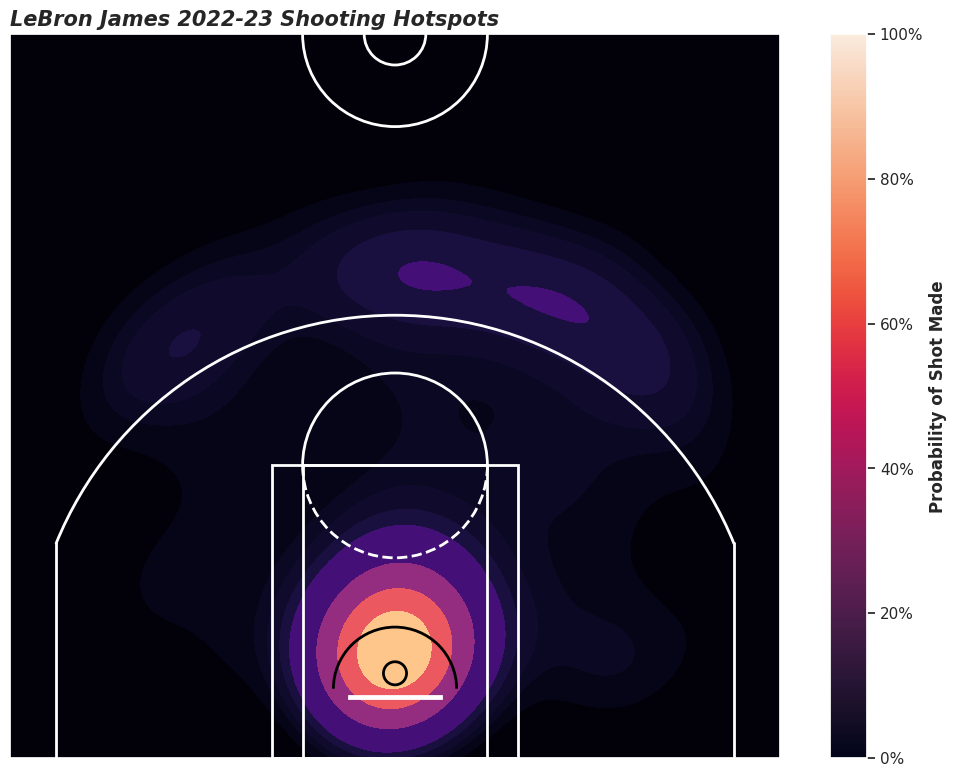

In [33]:
#Simulated player data
X = lebron23_ml.iloc[:, :-1].values
y = lebron23_ml.iloc[:, -1].values

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=15)

#Train a Gradient Boosting Classifier
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=3)
gb.fit(X_train, y_train)

#Predict probabilities for each shot
lebron23_ml['shot_probability'] = gb.predict_proba(lebron23_ml.iloc[:, :-1].values)[:, 1]

# Function to plot the basketball court and shooting hotspots using KDE contour plot
def plot_shooting_hotspots(data):
    # Plot the basketball court
    plt.figure(figsize=(13, 9.4))

    #Create KDE contour plot
    ax = sns.kdeplot(x=data["LOC_X"], y=data["LOC_Y"], fill=True, cmap="magma", levels=10, thresh=0, common_norm=False)

    #Explicitly show the colorbar with percentage labels
    cbar = plt.colorbar(ax.collections[0], label='Shooting Probability', format=FuncFormatter(lambda x, _: f'{int(x*100)}%'))

    plt.title('LeBron James 2022-23 Shooting Hotspots', fontsize=15, fontweight='bold', fontstyle='oblique', loc='left')
    plt.xticks([])
    plt.yticks([])  
    draw_court(outer_lines=False, color="white", lw=2)
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    cur_axes.axes.get_yaxis().set_visible(False)
    plt.xlim(-250, 250)
    plt.ylim(0, 470)
    plt.gca().set_aspect('equal', adjustable='box')

    #Colorbar
    cbar.set_label('Probability of Shot Made', fontweight='bold')
    plt.show()

#Plot the shooting hotspots on the court using KDE contour plot
plot_shooting_hotspots(lebron23_ml)

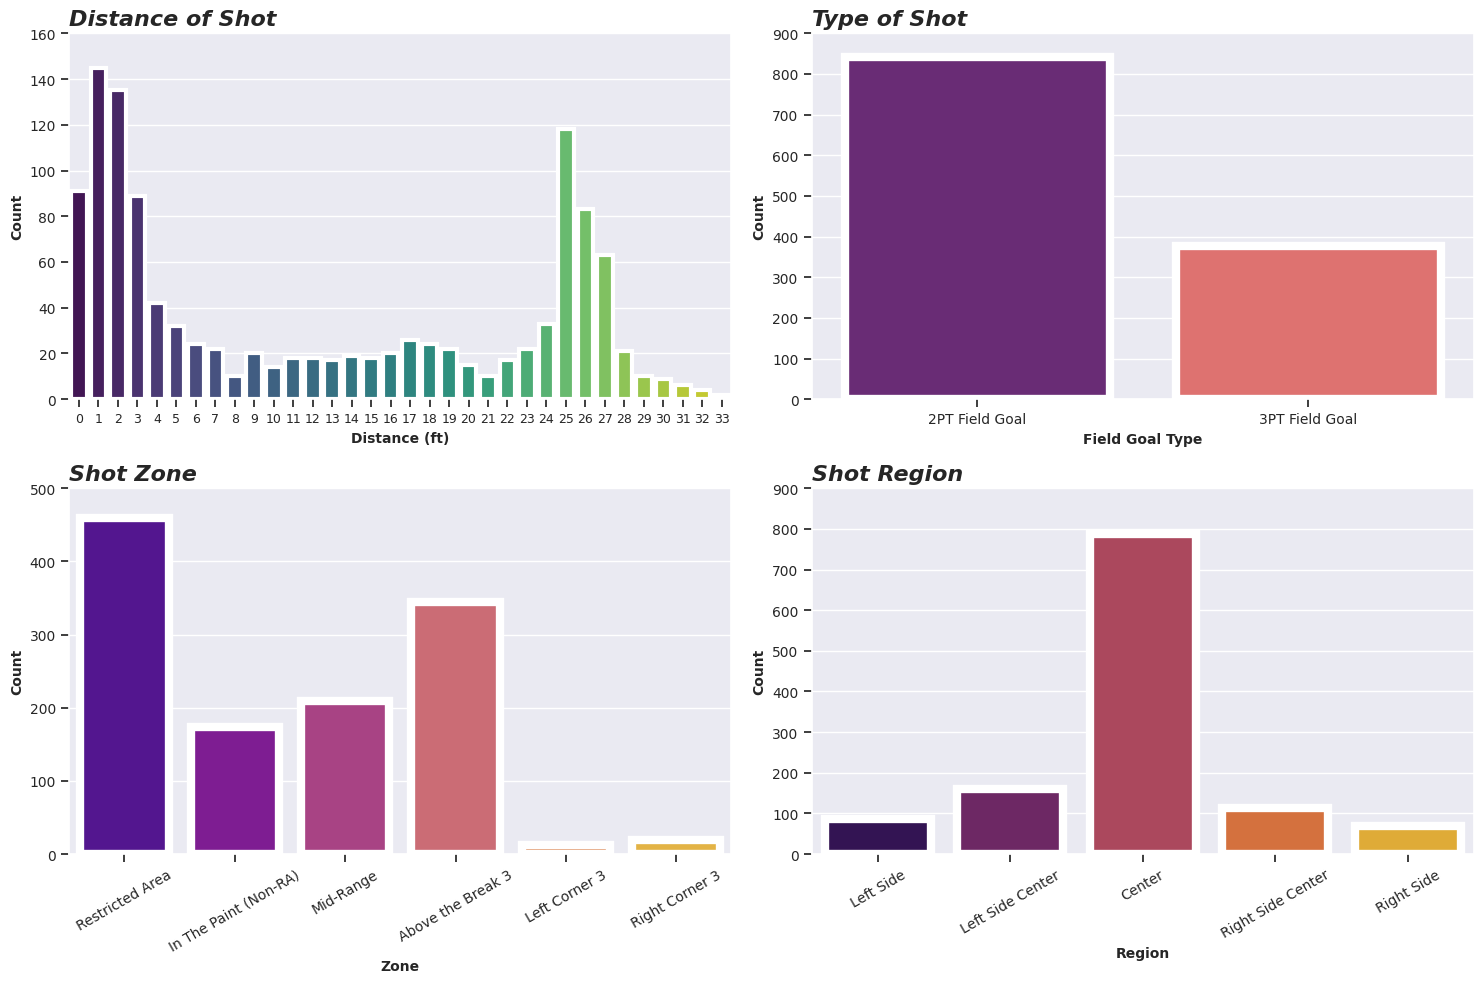

In [34]:
#Setting up subplots
fig, ax = plt.subplots(nrows=2, ncols=2)
sns.set_theme(style="darkgrid")

#Defining our Dataframe
df=lebron_23

#Plot 1
sns.countplot(x="SHOT_DISTANCE", data=df, ax=ax[0, 0], palette='viridis', edgecolor = "white", linewidth=3)
ax[0, 0].set_title('Distance of Shot', fontweight='bold', fontstyle='oblique', loc="left", size=16)
ax[0, 0].set_xlabel('Distance (ft)', size=10, fontweight='bold')
ax[0, 0].set_ylabel('Count', size=10, fontweight='bold')
ax[0, 0].set_xticks(ax[0, 0].get_xticks())
ax[0, 0].set_yticks(ax[0, 0].get_yticks())
ax[0, 0].set_xticklabels(ax[0, 0].get_xticklabels(), rotation=0, ha='center', size=9)
ax[0, 0].set_yticklabels(ax[0, 0].get_yticklabels(), rotation=0, ha='right', size=10)
ax[0, 0].tick_params(bottom=True, left=True)

#Plot 2
sns.countplot(x="SHOT_TYPE", data=df, ax=ax[0, 1], palette='magma', edgecolor = "white", linewidth=6, 
              order=['2PT Field Goal', '3PT Field Goal'])
ax[0, 1].set_title('Type of Shot', fontweight='bold', fontstyle='oblique', loc="left", size=16)
ax[0, 1].set_xlabel('Field Goal Type', size=10, fontweight='bold')
ax[0, 1].set_ylabel('Count', size=10, fontweight='bold')
ax[0, 1].set_xticks(ax[0, 1].get_xticks())
ax[0, 1].set_yticks(ax[0, 1].get_yticks())
ax[0, 1].set_xticklabels(ax[0, 1].get_xticklabels(), rotation=0, ha='center', size=10)
ax[0, 1].set_yticklabels(ax[0, 1].get_yticklabels(), rotation=0, ha='right', size=10)
ax[0, 1].tick_params(bottom=True, left=True)

#Plot 3
sns.countplot(x="BASIC_ZONE", data=df, ax=ax[1, 0], palette='plasma',edgecolor = "white", linewidth=6,
              order=['Restricted Area', 'In The Paint (Non-RA)', 'Mid-Range','Above the Break 3', 'Left Corner 3', 'Right Corner 3'])
ax[1, 0].set_title('Shot Zone', fontweight='bold', fontstyle='oblique', loc="left", size=16)
ax[1, 0].set_xlabel('Zone', size=10, fontweight='bold')
ax[1, 0].set_ylabel('Count', size=10, fontweight='bold')
ax[1, 0].set_xticks(ax[1, 0].get_xticks())
ax[1, 0].set_yticks(ax[1, 0].get_yticks())
ax[1, 0].set_xticklabels(ax[1, 0].get_xticklabels(), rotation=30, ha='center', size=10)
ax[1, 0].set_yticklabels(ax[1, 0].get_yticklabels(), rotation=0, ha='right', size=10)
ax[1, 0].tick_params(bottom=True, left=True)

#Plot 4
sns.countplot(x="ZONE_NAME", data=df, ax=ax[1, 1], palette='inferno', edgecolor = "white", linewidth=6, 
              order=['Left Side', 'Left Side Center', 'Center', 'Right Side Center', 'Right Side'])
ax[1, 1].set_title('Shot Region', fontweight='bold', fontstyle='oblique', loc="left", size=16)
ax[1, 1].set_xlabel('Region', size=10, fontweight='bold')
ax[1, 1].set_ylabel('Count', size=10, fontweight='bold')
ax[1, 1].set_xticks(ax[1, 1].get_xticks())
ax[1, 1].set_yticks(ax[0, 1].get_yticks())
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=30, ha='center', size=10)
ax[1, 1].set_yticklabels(ax[1, 1].get_yticklabels(), rotation=0, ha='right', size=10)
ax[1, 1].tick_params(bottom=True, left=True)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

LeBron's evolution is very interesting to see as he still attacks the basket in his 21st season with the same tenacity as when he did in his rookie season with the biggest change coming in his willingness to shoot more 3s, especially from that top right position which is his favorite.

# 5. ***Conclusion***

The NBA today finds itself in the middle of one of its most defining eras with the 3-point boom. With players like Stephen Curry being the poster child for this new era, the staggering effects of such a paradigm shift in the league but also in basketball as a whole have had indescribable impacts on how basketball at all levels is played, coached, and even examined. With the upward trend of NBA players attempting and making more 3-point shots from the beginning of the 21st century to the present being clear, the offensive capabilities of NBA teams (made evident with higher than-ever final point totals and player points per game) have reached levels never before seen. A change like this however doesn't come with the impact of just one player like Stephen Curry but with there being external factors or influences on and off the court which radically changed systems within the league. 

Starting around the *2013-14* and *2014-2015* seasons behind the scenes the NBA was also going through another revolution in the form of the analytics boom. Teams like the Houston Rockets with offensive-minded Head Coach Mike D'Antoni and star player James Harden were the faces of this new offensive-minded movement. If one individual and their team could be labeled as leading the way behind the scenes it was Houston Rockets General Manager Daryl Morey. With his analytics-focused basketball philosophy, labeled “Moreyball,” Morey pushed for his team to concentrate on more “statistical sound” shot attempts which focused less on mid-range shots and more on 3s and shots closer to the basket.

Morey's philosophy sent shockwaves through the NBA and other teams followed suit. Using data similar to how Morey did, in this study, we showcased how vital it is for coaches, trainers, and higher-up executives within teams to find and follow important trends. Such findings can then be acted upon to make well-informed decisions to prepare for the future of not just the NBA but of all of basketball.

# 6. ***Acknowledgments***

* **JP Hwang** for his substack and medium articles which inspired my use of heatmaps as a visualization tool.
>https://github.com/databyjp

* ****Bradley Fay**** and **Savvas Tjortjoglou** for providing a template for drawing NBA Courts within Python with the code in his Github.
>https://github.com/bradleyfay

    >https://savvastjortjoglou.com/nba-shot-sharts.html

* Thank you to **Dominic Samangy** for starting my interest in NBA data visualization with his incredible visuals on Twitter focusing on individual players and teams.
>https://github.com/DomSamangy

* Thank you to the Kaggle members and their datasets which made this project possible (links to all of them below)
>https://www.kaggle.com/datasets/sumitrodatta/nba-aba-baa-stats

    >https://www.kaggle.com/datasets/justinas/nba-players-data
    
    >https://www.kaggle.com/datasets/nathanlauga/nba-games